In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

1

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
from pycmqlib3.utility import dbaccess, dataseries, misc
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *
from pycmqlib3.strategy.signal_repo import *

C:\dev\akshare\akshare\__init__.py:2817: UserWarning: 为了支持更多特性，请将 Pandas 升级到 2.2.0 及以上版本！
  warnings.warn(
C:\dev\akshare\akshare\__init__.py:2822: UserWarning: 为了支持更多特性，请将 Python 升级到 3.9.0 及以上版本！
  warnings.warn(


In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

# define product groups and start times

In [4]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss', 'ao', 'si']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

# load historical data

In [5]:
tday = datetime.date(2024,5,30)

df = load_cnc_fut(tday, type='cnc')
#df = load_cnc_fut(tday, type='cal')

spot_df = load_fun_data(tday)

start_date = df.index[0]
end_date = tday

cdates = pd.date_range(start=start_date, end=tday, freq='D')
bdates = pd.bdate_range(start=start_date, end=end_date, freq='C', holidays=misc.CHN_Holidays)

cnc_fut_df data saved
spot_df data saved


In [21]:
#df = load_cnc_fut(tday, type='cal')

In [6]:
asset_pairs = [('rb', 'i'), ('hc', 'i'), ('j', 'i'), ('j', 'jm'), ('rb', 'hc')]
roll_win = 245
beta_ret_dict = {}
betas_dict = {}
for trade_asset, index_asset in asset_pairs:
    asset_df = df[[(index_asset, 'c1', 'close'), (trade_asset, 'c1', 'close')]].copy(deep=True).droplevel([1,2], axis=1)
    asset_df = asset_df.dropna(subset=[trade_asset]).ffill()

    for asset in asset_df:
        asset_df[f'{asset}_pct'] = asset_df[asset].pct_change().rolling(5).mean()
    asset_df['beta'] = asset_df[f'{index_asset}_pct'].rolling(244).cov(asset_df[f'{trade_asset}_pct'])/asset_df[f'{index_asset}_pct'].rolling(roll_win).var()
    key = '_'.join([trade_asset, index_asset])
    asset_df[key] = asset_df[trade_asset].pct_change() - asset_df['beta'] * asset_df[index_asset].pct_change().fillna(0)
    beta_ret_dict[key] = asset_df[key].dropna()
    betas_dict[key] = asset_df['beta']


In [7]:
spot_df['cu_base_phybas'] = spot_df['cu_smm_phybasis']
spot_df['al_base_phybas'] = spot_df['al_smm0_phybasis']
spot_df['zn_base_phybas'] = spot_df['zn_smm0_sh_phybasis']
spot_df['pb_base_phybas'] = spot_df['pb_smm1_sh_phybasis']
spot_df['ni_base_phybas'] = spot_df['ni_smm1_jc_phybasis']
spot_df['sn_base_phybas'] = spot_df['sn_smm1_sh_phybasis']
spot_df['ss_base_phybas'] = spot_df["ss_304_wuxi_phybasis"]
spot_df['cu_tc'] = spot_df['cu_mine_tc']
spot_df['zn_tc'] = spot_df['zn_50conc_tc_henan']
spot_df['pb_tc'] = spot_df['pb_50conc_tc_neimeng']
spot_df['sn_tc'] = spot_df['sn_40conc_tc_yunnan']

metal_inv_map = {
    'cu': 'cu_inv_social_all',
    'al': 'al_inv_social_all',
    'zn': 'zn_inv_social_3p',
    'ni': 'ni_inv_social_6p',
    'pb': 'pb_inv_social_5p',
    'sn': 'sn_inv_social_all',
    'si': 'si_inv_social_all',
    'ao': 'bauxite_inv_az_ports',
    'ss': "ss_inv_social_300",
    'rb': 'rebar_inv_social',
    'hc': 'hrc_inv_social',
    'j': "coke_inv_ports_tj",
    'jm': "ckc_inv_cokery",
    'v': "v_inv_social",
    'i': 'io_inv_45ports',
    'SM': 'sm_inv_mill',
    'SF': 'sf_inv_mill',
    'FG': "fg_inv_mill",
    'SA': 'sa_inv_mill_all',
}
for asset in metal_inv_map:
    spot_df[f'{asset}_sinv'] = spot_df[metal_inv_map[asset]]

In [ ]:
from pycmqlib3.utility.misc import day_shift, CHN_Holidays, prod2exch, is_workday, \
    nearby, contract_expiry, inst2contmth

fef_list = []
for nb in [2, 3, 4]:
    fef_nb = nearby('FEF', n=nb,
                    start_date=max(start_date, datetime.date(2016, 1, 1)),
                    end_date=tday,
                    roll_rule='-2b', freq='d', shift_mode=2, roll_col='settle')
    fef_nb.loc[fef_nb['settle'] <= 0, 'settle'] = np.nan
    fef_nb.loc[fef_nb['close'] <= 0, 'close'] = np.nan
    fef_list.append(fef_nb['settle'].to_frame(f'FEFc{nb-1}'))
    fef_list.append(fef_nb['close'].to_frame(f'FEFc{nb-1}_close'))
    fef_list.append(fef_nb['shift'].to_frame(f'FEFc{nb-1}_shift'))
fef_data = pd.concat(fef_list, axis=1)
fef_data.index = pd.to_datetime(fef_data.index)

In [8]:
for col in fef_data.columns:
    spot_df[col] = fef_data[col]
    
spot_df['hc_rb_diff'] = (np.log(df[('rb', 'c1', 'close')]).diff() - np.log(df[('hc', 'c1', 'close')]).diff()).cumsum()

spot_df['FEF_c1_c2_ratio'] = np.log((spot_df['FEFc1']/np.exp(spot_df['FEFc1_shift'])) / \
                             (spot_df['FEFc2']/np.exp(spot_df['FEFc2_shift'])))
spot_df['FEF_c123fly_ratio'] = np.log(spot_df['FEFc1'] * spot_df['FEFc3'] / \
                               (spot_df['FEFc2'] * spot_df['FEFc2']) * \
                               np.exp(2 * spot_df['FEFc2_shift'] - spot_df['FEFc1_shift'] - spot_df['FEFc3_shift']))
spot_df['FEF_ryield'] = (np.log(spot_df['FEFc1'] / np.exp(spot_df['FEFc1_shift'])) -
                         np.log(spot_df['FEFc2'] / np.exp(spot_df['FEFc2_shift']))) * 12
spot_df['FEF_basmom'] = np.log(1 + spot_df['FEFc1'].dropna().pct_change()) - \
                        np.log(1 + spot_df['FEFc2'].dropna().pct_change())
spot_df['FEF_basmom10'] = spot_df['FEF_basmom'].dropna().rolling(10).sum()
spot_df['FEF_basmom5'] = spot_df['FEF_basmom'].dropna().rolling(5).sum()    

NameError: name 'fef_data' is not defined

In [10]:
#product_list = df.
vol_win = 20
product_list = df.columns.get_level_values(0).unique()

for asset in product_list:    
    if (asset, 'c2', 'close') not in df.columns:
        print(asset)
        continue
    spot_df[f'{asset}_ryield'] = (np.log(df[(asset, 'c1', 'close')]) - np.log(df[(asset, 'c2', 'close')]) - 
                                  df[(asset, 'c1', 'shift')] + df[(asset, 'c2', 'shift')])/(df[(asset, 'c2', 'mth')] - df[(asset, 'c1', 'mth')])*12.0
    spot_df[f'{asset}_close'] = df[(asset, 'c1', 'close')]
    spot_df[f'{asset}_logret'] = np.log(df[(asset, 'c1', 'close')]).dropna().diff()
    spot_df[f'{asset}_pctchg'] = np.log(df[(asset, 'c1', 'close')]).dropna().pct_change()    
    spot_df[f'{asset}_logret2'] = np.log(df[(asset, 'c2', 'close')]).dropna().diff()
    spot_df[f'{asset}_basmom'] =spot_df[f'{asset}_logret'] - spot_df[f'{asset}_logret2']        
    spot_df[f'{asset}_pctvol'] = spot_df[f'{asset}_pctchg'].dropna().rolling(vol_win).std()
    spot_df[f'{asset}_basmom5'] = spot_df[f'{asset}_basmom'].dropna().rolling(5).sum()
    spot_df[f'{asset}_basmom10'] = spot_df[f'{asset}_basmom'].dropna().rolling(10).sum()
    spot_df[f'{asset}_basmom20'] = spot_df[f'{asset}_basmom'].dropna().rolling(20).sum()
    spot_df[f'{asset}_basmom60'] = spot_df[f'{asset}_basmom'].dropna().rolling(60).sum()
    

In [11]:
spot_df['cu_tc'] = spot_df['cu_mine_tc']
spot_df['zn_tc'] = spot_df['zn_50conc_tc_henan']
spot_df['pb_tc'] = spot_df['pb_50conc_tc_neimeng']
spot_df['sn_tc'] = spot_df['sn_40conc_tc_yunnan']

In [12]:
spot_df['consteel_dsales_mysteel'].dropna()

2021-11-10    181797.0
2021-11-11    224555.0
2021-11-12    160080.0
2021-11-15    177343.0
2021-11-16    198919.0
                ...   
2024-05-16    169667.0
2024-05-17    143033.0
2024-05-20    148714.0
2024-05-21    134031.0
2024-05-22    161804.0
Name: consteel_dsales_mysteel, Length: 595, dtype: float64

# feature study

In [104]:
vol_win=20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y']

# empiric_assets = [    
#     #'i', 'hc',
# #     'hc_i', 'rb_i',  'j_i',
#     'rb', #'hc', #'i', #'jm', 'i', 'v', 'FG', 'SF', 'SM',
#     #'rb-hc', #'pb',
#     #'rb_hc',
#     #'hc_i', 'rb_i',
#     #'cu', 'zn', 'pb', 'sn', 'al', 'ni', 'ss', #'si', 'ao', # 'cu', 'al', 'zn', 'ni', 'pb', 'sn', 'ss', # 
# ]

empiric_assets = [
    'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'SM', 'SF', 
    'cu', 'al', 'zn', 'ni', 'pb', 'sn', 'ss', #'si', #'bc'
    'ru', 'l', 'pp', 'TA', 'sc', 'eb', 'eg', 'UR', 'lu', 
    'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 
    'CF', 'jd', 'AP', 'lh', 
]

traded_price = 'close'
df_pxchg = pd.DataFrame(index=df.index)

for asset in empiric_assets:
    if '_' in asset:
        df_pxchg[asset] = beta_ret_dict[asset].dropna()
    elif '-' in asset:
        for sub_asset in asset.split('-'):
            if sub_asset not in empiric_assets:
                df_pxchg[sub_asset] = df[(sub_asset, 'c1', traded_price)].dropna().pct_change()                
    else:
        df_pxchg[asset] = df[(asset, 'c1', traded_price)].dropna().pct_change()
vol_df = df_pxchg.rolling(vol_win).std()

customerized signal

sharpe        0.119990
sharpe_6m     0.631820
sharpe_1y     1.365781
sharpe_2y     0.213859
sharpe_3y     0.174969
sharpe_4y     0.151603
sharpe_5y     0.135527
sharpe_6y     0.123718
sharpe_7y     0.119990
sharpe_8y     0.119990
sharpe_9y     0.119990
sharpe_10y    0.119990
Name: total, dtype: float64
                  rb
sharpe      0.120029
sharpe_6m   0.631820
sharpe_1y   1.365781
sharpe_2y   0.213859
sharpe_3y   0.174969
sharpe_4y   0.151603
sharpe_5y   0.135527
sharpe_6y   0.123718
sharpe_7y   0.120029
sharpe_8y   0.120029
sharpe_9y   0.120029
sharpe_10y  0.120029
    pnl_per_trade   turnover
rb       8.890069  22.052957


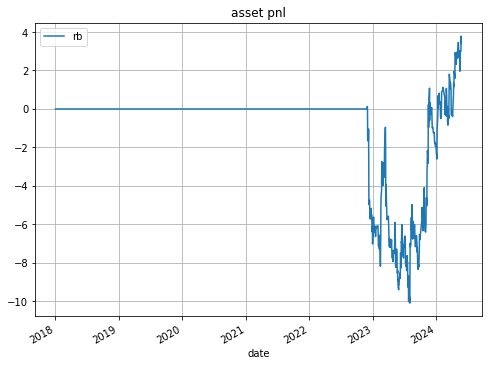

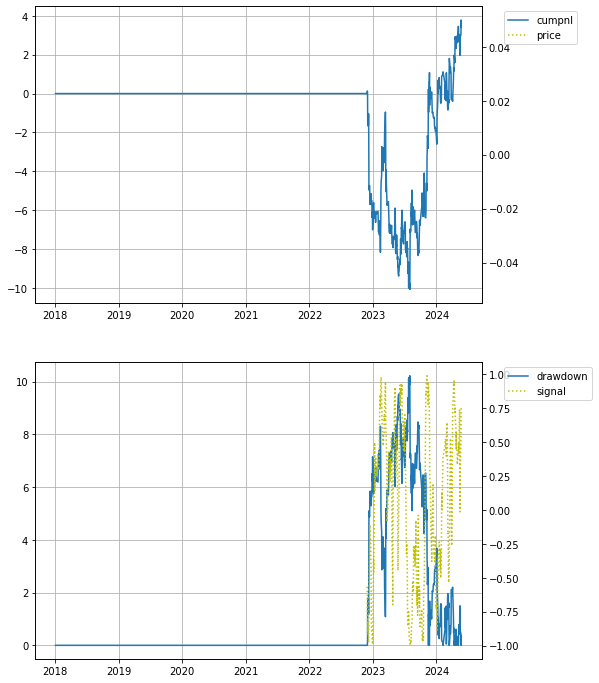

In [103]:
cutoff='2010-01-01'

signal_cap = [-2.0, 2.0]
chg_func = 'diff'
bullish = True
vol_win = 120
signal_func = 'hlratio'
param_rng = [20, 60, 2]

feature = 'rebar_sales_inv_ratio'
#feature = 'FEF_c123fly_ratio'
#'ni_npi_10-15_sh' #'ni_nis_cjb_spot' # 'ni_mhp_34_ports' #"ni_1.5conc_spot_rz" #'ni_npi_10-15_sh'
#feature = 'prem_bonded_cif'
freq='W-Thu'

signal_df = pd.DataFrame(index=df_pxchg.index)
signal_dict = {}
for asset in empiric_assets:
    #feature_ts = df[(asset, 'c1', 'close')].dropna()
    #ticker, param_rng = feature_map[asset]    
    feature_ts = spot_df[feature].dropna() #.pct_change()        
    #feature_ts = spot_df[feature].ffill().reindex(index=pd.date_range(start=df.index[0], end=df.index[-1], freq=freq)).ffill().dropna()
    #feature_ts = spot_df[f'{asset}_{feature}'].dropna()        
    #feature_ts = np.log(feature_ts)
#     if asset in ['cu', 'al']:
#         #param_rng = [1, 2, 1]
#         feature_ts = feature_ts.rolling(20).mean()
#     else:
#         #param_rng = [1, 2, 1]
#         feature_ts = feature_ts.rolling(2).mean()
    feature_ts = feature_ts.reindex(index=cdates).ffill().reindex(index=bdates)
    feature_ts = feature_ts.ewm(3).mean()
    feature_ts = yoy_generic(feature_ts, label_func=lunar_label, group_col='label_day', func=chg_func)
    
    signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap, vol_win=vol_win)
    #signal_ts = hlratio(feature_ts, 250)
    #signal_ts = signal_hysteresis(signal_ts, 0.7, 0.1)
    # signal_ts = seasonal_score(feature_ts.to_frame(), backward=10, forward=10, rolling_years=3, min_obs=10)
    # signal_ts = seasonal_score(feature_ts.to_frame(), backward=15, forward=15, rolling_years=3, min_obs=30)

    if not bullish:
        signal_ts = -signal_ts    
    
    #signal_ts = signal_ts.reindex(index=cdates).ffill().reindex(index=df_pxchg.index).ffill()    
    signal_ts = signal_ts.ewm(1).mean()
    #signal_ts = signal_hump(signal_ts, 0.2)
    if '-' in asset:
        sub_assets = asset.split('-')
        if sub_assets[0] in signal_df.columns:
            signal_df[sub_assets[0]] += signal_ts
        else:
            signal_df[sub_assets[0]] = signal_ts
        if sub_asset[1] in signal_df.columns:
            signal_df[sub_assets[1]] -= signal_ts
        else:
            signal_df[sub_assets[1]] = -signal_ts            
    else:
        signal_df[asset] = signal_ts

#signal_df = xs_demean(signal_df)

holding = generate_holding_from_signal(signal_df, vol_df, risk_scaling=1.0, asset_scaling=False)

bt_metrics = MetricsBase(holdings=holding[cutoff:],
                         returns=df_pxchg[cutoff:], shift_holdings=1)

pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=False, tenors=pnl_tenors)

print(pnl_stats['sharpe'])
print(pnl_stats['asset_sharpe_stats'])

print(pd.DataFrame({key: pnl_stats[key] for key in ['pnl_per_trade', 'turnover']}))

pnl_stats['asset_cumpnl'].plot(figsize=(8,6))
plt.grid()
plt.title('asset pnl')

plot_signal_pnl(pnl_stats['portfolio_cumpnl'], signal=signal_ts, asset_price=df_pxchg.iloc[0].cumsum(), figsize=(8, 12))


In [82]:
holding.max()
#pnl_stats['portfolio_pnl'].std()

rb    114.565523
hc    140.279071
dtype: float64

In [93]:
feature_setup = {
    'pbf_mix_spd_hys': [['fef', 'i'],
                        ['pbf_iocj_ssf_spd', 'hysteresis', [0.5, 500, 0.5], "",  "hlratio", False, "", "", 120]],
    'landsales_yoy_ma': [['rb', 'hc'], ['top100cities_land_supplied_area_res_all',
                                        'ma', [4, 8], 'lunar_yoy_day', 'diff', True, "", "", 52]],
    'prop2hand_px_qtl': [['rb', 'hc'], ['prop_2ndhand_px_idx', 'qtl', [50, 55], '', '', True, "", "", 120]],

    'fef_phycarry_ema': [['fef', 'i'],
                         ['FEF_phycarry', 'ema', [1, 2, 1], '', '', True, 'price', "ema1", 120]],
    'rb_phycarry_ema': [['fef', 'rb', 'i', 'j', 'jm'],
                        ['rb_phycarry', 'ema', [10, 20, 1], '', '', True, '', "sma3", 120]],
    'hc_phycarry_ema': [['fef', 'hc', 'i', 'j', 'jm'],
                        ['hc_phycarry', 'ema', [10, 20, 1], '', '', True, '', "sma3", 120]],
    'ckc_phycarry_ema': [['fef', 'i'],
                         ['jm_phycarry', 'ema', [10, 20, 1], '', '', True, '', "sma3", 120]],
    'fef_c1_c2_ratio_or_qtl': [['rb', 'hc', 'j'],
                               ['FEF_c1_c2_ratio', 'hlratio', [40, 60, 2], 'ema1', '', False, '', "", 120]],
    'fef_c1_c2_ratio_spd_qtl': [['rb_i', 'hc_i'],
                                ['FEF_c1_c2_ratio', 'qtl', [30, 60, 2], '', '', False, '', "hmp0.2", 120]],
    'fef_fly_ratio_or_qtl': [['rb', 'hc', 'j'],
                             ['FEF_c123fly_ratio', 'hlratio', [40, 60, 2], 'ema1', '', False, '', "hmp0.2", 120]],
    # 'fef_fly_ratio_spd_qtl': [['rb_i', 'hc_i'],
    #                           ['FEF_c123_fly_ratio', 'qtl', [40, 60, 2], '', '', False, '', "", 120]],
    'fef_ryieldmom_or_zs': [['rb', 'hc', 'j'],
                            ['FEF_ryield', 'zscore', [10, 80, 2], 'ema3', '', False, '', "", 120]],
    'fef_ryieldmom_spd_zs': [['rb_i', 'hc_i'],
                             ['FEF_ryield', 'zscore', [10, 80, 2], 'ema1', '', False, '', "hmp0.4", 120]],
    'fef_basmom_or_qtl': [['rb', 'hc', 'j'],
                          ['FEF_basmom', 'qtl', [60, 80, 2], 'ema20', '', False, 'price', "ema1", 120]],
    'fef_basmom5_or_qtl': [['rb', 'hc', 'j'],
                          ['FEF_basmom5', 'qtl', [60, 80, 2], 'ema5', '', False, 'price', "", 120]],
    'fef_basmom_spd_qtl': [['rb_i', 'hc_i'],
                           ['FEF_basmom', 'qtl', [60, 80, 2], 'ema20', '', False, 'price', "hmp0.2", 120]],
    'fef_basmom5_spd_qtl': [['rb_i', 'hc_i'],
                           ['FEF_basmom5', 'qtl', [40, 80, 2], 'ema3', '', False, 'price', "hmp0.2", 120]],    
    'fef_basmom_or_ema': [['rb', 'hc', 'j'],
                          ['FEF_basmom5', 'ema', [3, 6], '', '', False, 'price', "ema1", 120]],
    'fef_basmom_spd_ema': [['rb_i', 'hc_i'],
                           ['FEF_basmom5', 'ema', [3, 6], '', '', False, 'price', "ema1", 120]],

    'pbf_arb_hlr': [['rb', 'hc', 'i', 'j', 'jm'],
                    ['pbf_imp_profit', 'hlratio', [40, 80, 2], '', '', True, 'price', 'sma3', 120]],
    'pbf_arb_hlrhys': [['rb', 'hc', 'i', 'j', 'jm'],
                       ['pbf_imp_profit', 'hysteresis', [0.7, 240, 0.1], '', 'hlratio', False, '', 'ema1', 120]],
    'ioarb_px_hlr': [['rb', 'hc', 'i'],
                     ['io_on_off_arb', 'hlratio', [40, 80, 2], 'sma2', '', False, 'price', '', 120]],
    'ioarb_px_hlrhys': [['rb', 'hc', 'i'],
                        ['io_on_off_arb', 'hlratio', [40, 80, 2], 'sma2', '', False, 'price', '', 120]],
    'ioarb_spd_qtl_1y': [['rb_i', 'hc_i'],
                         ['io_on_off_arb', 'qtl', [240, 260, 2], 'sma2', '', False, 'price', '', 120]],

    'io_removal_lvl': [['i'],
                       ['io_removal_41ports', 'qtl', [20, 40, 2], '', '', True, 'price', 'sma2', 120]],
    'io_removal_lyoy': [['i'],
                        ['io_removal_41ports', 'qtl', [6, 10], 'lunar_yoy_day', 'diff', True, 'W-Fri', '', 120]],
    'io_inv_rmv_ratio_1y': [['i'],
                            ['io_inv_removal_ratio_41p', 'hlratio', [48, 56], 'df1', 'pct_change', False, '', "", 120]],
    'io_inv_rmv_diff_lyoy_1y': [['i'],
                            ['io_inv_rmv_pctchg_41p', 'hlratio', [48, 56], 'lunar_yoy_day', 'diff', False, '', "", 120]],
    'io_millinv_lvl': [['i'],
                       ['io_inv_mill(64)', 'qtl', [20, 40, 2], '', '', True, 'price', '', 120]],
     'io_millinv_lyoy': [['hc', 'i'],
                        ['io_inv_mill(64)', 'qtl', [2, 4], 'lunar_yoy_day', 'diff', True, 'W-Fri', '', 120]],
    'io_invdays_lvl': [['rb', 'hc', 'i', 'j', 'jm', 'v', 'FG', 'cu', 'al'],
                       ['io_invdays_imp_mill(64)', 'qtl', [20, 40, 2], '', 'pct_change', True, 'price', '', 120]],
    'io_invdays_lyoy': [['i'],
                        ['io_invdays_imp_mill(64)', 'qtl', [2, 4], 'lunar_yoy_day', 'pct_change', True, 'W-Fri', "", 120]],
    'io_pinv31_lvl_zsa': [['rb_i', 'hc_i'],
                          ['io_inv_31ports', 'zscore_adj', [8, 56, 4], '', '', True, '', "sma2", 120]],
    'io_pinv45_lvl_hlr': [['rb_i', 'hc_i'],
                          ['io_inv_45ports', 'hlratio', [8, 56, 4], '', '', True, '', "sma2", 120]],
    # 'io_port_inv_lvl_slow': [['i'],
    #                          ['io_inv_imp_31ports_w', 'zscore', [240, 255, 5], '', '', False, 'price', "", 120]],
    'long_sinv_mds_st': [['rb', 'hc', 'i'],
                        ['long_social_inv', 'ma_dff_sgn', [40, 60, 2], '', '', False, 'price', "sma2", 120]],
    'long_sinv_mds_lt': [['rb', 'hc', 'i'],
                        ['long_social_inv', 'ma_dff_sgn', [240, 250, 2], '', '', False, 'price', "sma2", 120]],
    'long_sinv_lyoy_mds_st': [['rb', 'hc', 'i'], ['long_social_inv', 'ma_dff_sgn', [40, 60, 2],
                                                 'lunar_yoy_day', 'diff', False, 'price', "sma2", 120]],
    'long_sinv_lyoy_mds_lt': [['rb', 'hc', 'i'], ['long_social_inv', 'ma_dff_sgn', [240, 250, 2],
                                                 'lunar_yoy_day', 'diff', False, 'price', "sma2", 120]],
    'flat_sinv_mds_st': [['rb', 'hc', 'i'],
                        ['flat_social_inv', 'ma_dff_sgn', [40, 60, 2], '', '', False, 'price', "sma2", 120]],
    'flat_sinv_mds_lt': [['rb', 'hc', 'i'],
                        ['flat_social_inv', 'ma_dff_sgn', [240, 250, 2], '', '', False, 'price', "sma2", 120]],
    'steel_sinv_lyoy_zs': [['rb', 'hc', 'i', 'FG', 'v'],
                           ['steel_inv_social', 'zscore', [24, 30, 2], 'lunar_yoy_day', 'diff', False, '', "", 120]],
    'steel_sinv_lyoy_mds': [['rb', 'hc', 'i', 'FG', 'v'],
                           ['steel_inv_social', 'ma_dff_sgn', [5, 9, 1], 'lunar_yoy_day', 'diff', False, '', "", 120]],
    'rbhc_dmd_mds': [['rb-hc'],
                     ['rb_hc_dmd_diff', 'ma_dff_sgn', [5, 9, 1], '', '', True, '', "", 120]],
    'rbhc_dmd_lyoy_mds': [['rb-hc'],
                          ['rb_hc_dmd_diff', 'ma_dff_sgn', [5, 9, 1], 'lunar_yoy_day', 'diff', True, '', "", 120]],
    'rbhc_sinv_mds': [['rb-hc'],
                      ['rb_hc_sinv_diff', 'ma_dff_sgn', [5, 9, 1], '', '', False, '', "", 120]],
    'rbhc_sinv_lyoy_mds': [['rb-hc'],
                           ['rb_hc_sinv_diff', 'ma_dff_sgn', [5, 9, 1], 'lunar_yoy_day', 'diff', False, '', "", 120]],
    # 'rb_sinv_lyoy_fast': ('rebar_inv_social', 'zscore', [20, 42, 2], 'lunar_yoy_day', 'diff', False, 'W-Fri'),
    # 'wr_sinv_lyoy_fast': ('wirerod_inv_social', 'zscore', [20, 42, 2], 'lunar_yoy_day', 'diff', False, 'W-Fri'),
    # 'hc_soinv_lyoy_fast': ('hrc_inv_social', 'zscore', [20, 42, 2], 'lunar_yoy_day', 'diff', False, 'W-Fri'),
    # 'cc_soinv_lyoy_fast': ('crc_inv_social', 'zscore', [20, 42, 2], 'lunar_yoy_day', 'diff', False, 'W-Fri'),
    # 'billet_inv_chg_slow': ('billet_inv_social_ts', 'zscore', [240, 252, 2], '', 'diff', False, 'price'),
    'cons_steel_lyoy_slow': [['rb', 'i', 'hc'],
                             ['cons_steel_transact_vol_china', 'zscore', [240, 255, 5],
                              'lunar_yoy_day', 'diff', True, 'price', "", 120]],

    # 'margin_sea_lvl_mid': ('hrc_margin_sb', 'zscore', [40, 82, 2], '', 'pct_change', True, 'price'),
    'hrc_arb_mom': [['hc', 'rb'],
                    ['hrc_exp_sea_arb', 'qtl', [40, 80, 2], '', '', True, '', "ema1", 120]],
    'hrc_arb_ma': [['hc', 'rb'],
                   ['hrc_exp_sea_arb', 'ma', [1, 4, 1], '', '', True, '', "ema1", 120]],
    'steel_margin_lvl_fast': [['rb', 'hc', 'i', 'j'],
                              ['margin_hrc_macf', 'qtl', [20, 40, 2], '', '', True, 'price', "", 120]],
    'strip_hsec_lvl_mid': [['rb', 'hc', 'i', 'j', 'jm'],
                           ['strip_hsec', 'qtl', [60, 80, 2], '', '', True, 'price', "", 120]],
    'macf_cfd_lvl_mid': [['i'],
                         ['macf_cfd', 'qtl', [40, 82, 2], '', '', True, 'price', "", 120]],
    'hc_rb_diff_lvl_fast': [['rb', 'hc', 'i', 'j', 'jm', 'cu', 'al'],
                            ['hc_rb_diff', 'zscore', [20, 40, 2], '', '', True, 'price', "", 120]],

    'cu_prem_usd_zsa': [['cu'],
                        ['cu_prem_bonded_warrant', 'zscore_adj', [20, 30, 2], '', '', True, 'price', "", 120]],
    'cu_prem_usd_md': [['cu'],
                       ['cu_prem_bonded_warrant', 'ma_dff', [20, 30, 2], '', '', True, 'price', "", 120]],
    'cu_phybasis_zsa': [['cu'],
                        ['cu_cjb_phybasis', 'zscore_adj', [40, 60, 2], 'sma10', '', True, 'price', "", 120]],  # great
    'cu_phybasis_hlr': [['cu'],
                        ['cu_cjb_phybasis', 'hlratio', [40, 60, 2], 'sma10', '', True, 'price', "", 120]],  # great
    'cu_scrap1_zs': [['cu'],
                     ['cu_1#_scrap_diff', 'zscore', [40, 60, 2], '', '', True, 'price', "", 120]],
    'cu_mine_tc_zs': [['cu'],
                      ['cu_mine_tc_cif_cn', 'zscore', [20, 30, 2], '', '', False, 'price', "", 120]],
    'cu_rod_procfee_for_qtl': [['cu'],
                      ['cu_rod_lowoxygen_8mm_procfee_for_gd', 'qtl', [20, 30, 2], '', '', True, 'price', "", 120]],
    # 'cu_scrap1_margin_gd': [['cu'],
    #                         ['cu_scrap1_diff_gd', 'qtl', [40, 60, 2], '', 'pct_change', True, 'price', "", 120]],
    # 'cu_scrap1_margin_tj': [['cu'],
    #                         ['cu_scrap1_diff_tj', 'qtl', [40, 60, 2], '', 'pct_change', True, 'price', "", 120]],
    # 'cu_rod_procfee_2.6': [['cu'], ['cu_rod_2.6_procfee_nanchu',
    #                                 'zscore_adj', [20, 30, 2], '', 'pct_change', True, 'price', "", 120]],
    # 'cu_rod_procfee_8.0': [['cu'], ['cu_rod_8_procfee_nanchu',
    #                                 'zscore_adj', [20, 30, 2], '', 'pct_change', True, 'price', "", 120]],
    'ni_nis_mom_qtl': [['ni'], ['ni_nis_cjb_spot', 'qtl', [10, 20, 2], '', '', True, '', "", 120]],
    'ni_ore_qtl': [['ni'], ['ni_1.8conc_spot_php_lianyungang', 'qtl', [10, 20], '', '', True, '', "", 120]],
    'al_alumina_qtl': [['al'],
                       ["alumina_spot_qd", 'qtl', [10, 20], '', '', True, 'price', "", 120]],
    'al_alumina_yoy_qtl': [['al'],
                           ["alumina_spot_qd", 'qtl', [20, 40], 'cal_yoy_day', 'pct_change', True, 'price', "", 120]],
    'al_coal_qtl': [['al'],
                    ['coal_5500_sx_qhd', 'qtl', [240, 250], '', '', True, 'price', "", 120]],
    'al_coal_yoy_qtl': [['al'],
                        ['coal_5500_sx_qhd', 'qtl', [20, 40], 'cal_yoy_day', 'pct_change', True, 'price', "", 120]],
    'sn_conc_spot_hlr': [['sn'], ['sn_60conc_spot_guangxi', 'hlratio', [40, 80, 2], '', '', True, '', "", 120]],
    
    
    'al_scrap_sh_zs': [['al'],
                       ['al_scrap_ex_diff_sh', 'zscore', [20, 30, 2], '', '', True, 'price', "", 120]],
    'zn_hrc_mom': [['zn'], ['hrc_sh', 'qtl', [20, 30], '', '', True, 'price', "", 120]],
    'pb_sec_margin_zs': [['pb'], ['pb_sec_margin', 'zscore', [230, 250, 2], '', '', False, 'price', "", 120]],    
    'ni_npi_cn_zs': [['ni'], ['npi_10_spot_cn', 'zscore', [40, 80, 2], '', '', True, '', "", 120]],
    'ni_nsa_zs': [['ni'], ['ni_sul_spot', 'zscore', [40, 80, 2], '', '', True, '', "", 120]],
    'ni_briq_qtl': [['ni'], ['ni_briq_prem_spot', 'qtl', [40, 60, 2], '', '', True, '', "", 120]],
    'ni_npi_prem_hlr': [['ni'], ['ni_ni_prem', 'hlratio', [20, 60, 2], 'ema3', '', False, '', "", 120]],
    'ni_npi_imp_spd_hlr': [['ni'], ['npi_ferronickle_spd', 'hlratio', [20, 60, 2], '', '', False, 'price', "", 120]],    

    'lme_base_ts_mds': [['cu', 'al', 'zn', 'pb', 'ni', 'sn'],
                        ['lme_base_ts', 'ma_dff_sgn', [10, 30, 2], '', '', True, 'price', "", 120]],
    'lme_base_ts_mds_xdemean': [['cu', 'al', 'zn', 'pb', 'ni', 'sn'],
                                ['lme_base_ts', 'ma_dff_sgn', [10, 30, 4], '', '', True, 'price', "", 120]],
    'lme_base_ts_hlr': [['cu', 'al', 'zn', 'pb', 'ni', 'sn'],
                        ['lme_base_ts', 'hlratio', [10, 20, 2], '', '', True, 'price', "", 120]],
    'lme_base_ts_hlr_xdemean': [['cu', 'al', 'zn', 'pb', 'ni', 'sn'],
                                ['lme_base_ts', 'hlratio', [10, 20, 2], '', '', True, 'price', "", 120]],
    'base_phybas_carry_ma': [['cu', 'al', 'zn', 'ni', 'sn'],
                             ['base_phybas', 'ma', [1, 2], 'sma2', '', True, 'price', "", 120]],
    'base_phybas_carry_ma_xdemean': [['cu', 'al', 'zn', 'ni', 'sn'],
                                     ['base_phybas', 'ma', [1, 2], 'sma2', '', True, 'price', "", 120]],
    'base_phybasmom_1m_zs': [['cu', 'al', 'zn', 'pb', 'ni', 'sn'],
                             ['base_phybas', 'zscore', [20, 30], 'sma2', '', True, 'price', "", 120]],
    'base_phybasmom_1m_zs_xdemean': [['cu', 'al', 'zn', 'pb', 'ni', 'sn'],
                                     ['base_phybas', 'zscore', [20, 30], 'sma2', '', True, 'price', "", 120]],
    'base_phybasmom_1y_zs': [['cu', 'al', 'zn', 'pb', 'ni', 'sn'],
                             ['base_phybas', 'zscore', [230, 250, 2], 'sma2', '', True, 'price', "", 120]],
    'base_phybasmom_1y_zs_xdemean': [['cu', 'al', 'zn', 'pb', 'ni', 'sn'],
                                     ['base_phybas', 'zscore', [230, 250, 2], 'sma2', '', True, 'price', "", 120]],
    'base_cifprem_1y_zs': [['cu', 'al', 'zn', 'ni'],
                           ['prem_bonded_warrant', 'zscore', [230, 250, 2], '', '', True, 'price', "", 120]],
    'base_cifprem_1y_zs_xdemean': [['cu', 'al', 'zn', 'ni'],
                                   ['prem_bonded_warrant', 'zscore', [230, 250, 2], '', '', True, 'price', "", 120]],
    'base_tc_1y_zs': [['cu', 'pb', 'zn'], ['base_tc', 'zscore', [230, 250, 2], '', '', False, 'price', "", 120]],
    'base_tc_2y_zs': [['cu', 'pb', 'zn'], ['base_tc', 'zscore', [720, 750, 2], '', '', False, 'price', "", 120]],
    'base_inv_mds': [['cu', 'al', 'zn', 'pb', 'ni', 'sn'],
                     ['base_inv', 'ma_dff_sgn', [180, 240, 2], '', '', False, 'price', "", 120]],
    'base_inv_mds_xdemean': [['cu', 'al', 'zn', 'pb', 'ni', 'sn'],
                             ['base_inv', 'ma_dff_sgn', [180, 240, 2], '', '', False, 'price', "", 120]],
    'lmebase_arb_zsa_1m': [['MCU', 'MAL', 'MZN', 'MPB', 'MNI'],
                           ['shfe_arb', 'zscore_adj', [20, 40, 1], 'ema3', '', True, 'price', "", 120]],
    'lmebase_arb_zsa_1m_xdemean': [['MCU', 'MAL', 'MZN', 'MPB', 'MNI'],
                                   ['shfe_arb', 'zscore_adj', [20, 40, 1], 'ema3', '', True, 'price', "", 120]],
    'lmebase_arb_ma': [['MCU', 'MAL', 'MZN', 'MPB', 'MNI'],
                       ['shfe_arb', 'ma', [1, 2], '', '', True, 'price', "", 240]],
    'lmebase_arb_ma_xdemean': [['MCU', 'MAL', 'MZN', 'MPB', 'MNI'],
                               ['shfe_arb', 'ma', [1, 2], '', '', True, 'price', "", 240]],
    'lmebase_long_2y': [['MCU', 'MAL', 'MZN', 'MPB', 'MNI'],
                        ['shfe_arb', 'hysteresis', [0.9, 500, 0.1], '', 'pct_score', True, 'price', "pos", 240]],
    'lme_mr_zs_xdemean': [['MCU', 'MAL', 'MZN', 'MPB'],
                          ['px', 'zscore', [20, 160, 2], '', '', False, '', "ema4", 240]],

    'metal_pbc_ema': [['i', 'rb', 'hc', 'jm', 'j', 'SM', 'SF', 'FG', 'v', 'cu', 'al', 'zn', 'ni', 'pb', 'sn', 'ss'],
                      ['metal_pbc', 'ema', [10, 20], '', '', True, 'price', "", 120]],
    'metal_pbc_ema_xdemean': [['i', 'rb', 'hc', 'jm', 'j', 'SM', 'SF', 'FG', 'v',
                               'cu', 'al', 'zn', 'ni', 'pb', 'sn', 'ss'],
                              ['metal_pbc', 'ema', [10, 20], '', '', True, 'price', "", 120]],
    'metal_mom_hlrhys': [['i', 'rb', 'hc', 'jm', 'j', 'SM', 'SF', 'FG', 'v', 'cu', 'al', 'zn', 'ni', 'pb', 'sn', 'ss'],
                         ['metal_px', 'hysteresis', [0.7, 60, 0.1], '', 'hlratio', True, 'price', "ema1", 120]],
    'metal_mom_hlrhys_xdemean': [['i', 'rb', 'hc', 'jm', 'j', 'SM', 'SF', 'FG', 'v', 'cu', 'al', 'zn', 'ni', 'pb', 'sn', 'ss'],
                         ['metal_px', 'hysteresis', [0.7, 60, 0.1], '', 'hlratio', True, 'price', "ema1", 120]],
    'metal_inv_hlr': [['i', 'rb', 'hc', 'jm', 'j', 'SM', 'SF', 'FG', 'v', 'cu', 'al', 'zn', 'ni', 'pb', 'sn', 'ss'],
                      ['metal_inv', 'hlratio', [240, 250], '', '', False, 'price', "", 120]],
    'metal_inv_hlr_xdemean': [['i', 'rb', 'hc', 'jm', 'j', 'SM', 'SF', 'FG', 'v',
                               'cu', 'al', 'zn', 'ni', 'pb', 'sn', 'ss'],
                              ['metal_inv', 'hlratio', [240, 250, 2], '', '', False, 'price', "", 120]],
    'metal_inv_lyoy_hlr': [['i', 'rb', 'hc', 'jm', 'j', 'SM', 'SF', 'FG', 'v',
                            'cu', 'al', 'zn', 'ni', 'pb', 'sn', 'ss'],
                           ['metal_inv', 'hlratio', [240, 250], 'lunar_yoy_day', 'pct_change', False, 'price', "", 120]],
    'metal_inv_lyoy_hlr_xdemean': [['i', 'rb', 'hc', 'jm', 'j', 'SM', 'SF', 'FG', 'v',
                                    'cu', 'al', 'zn', 'ni', 'pb', 'sn', 'ss'],
                                   ['metal_inv', 'hlratio', [240, 250], 'lunar_yoy_day',
                                    'pct_change', False, 'price', "", 120]],

    "base_etf_mom_zsa": [['cu', 'al', 'zn', 'ni', 'pb', 'sn'],
                         ["base_sw_csi500_ret", "zscore_adj", [20, 40, 1], "csum", "", True, "", "", 120]],
    "base_etf_mom_ewm": [['cu', 'al', 'zn', 'ni', 'pb', 'sn'],
                         ["base_sw_csi500_ret", "ewmac", [2, 4, 1], "csum", "", True, "", "", 120]],
    "const_etf_mom_zsa": [['rb', 'i', 'v', 'FG'],
                          ["const_sw_csi500_ret", "zscore_adj", [40, 80, 2], "csum", "", True, "", "", 120]],
    "const_etf_mom_ewm": [['rb', 'i', 'v', 'FG'],
                          ["const_sw_csi500_ret", "ewmac", [2, 5, 1], "csum", "", True, "", "", 120]],

    "prop_etf_mom_dbth_zs": [['rb', 'i', 'v', 'FG'],
                             ["prop_sw_csi500_ret", "hysteresis", [1, 120, 0.5], "ema3", "zscore_roll", True, "", "", 120]],
    "prop_etf_mom_dbth_qtl": [['rb', 'i', 'v', 'FG'],
                              ["prop_sw_csi500_ret", "dbl_th", [0.75, 120, 0], "ema3", "pct_score", True, "", "", 120]],
    "prop_etf_mom_dbth_qtl2": [['rb', 'i', 'v', 'FG'],
                               ["prop_sw_csi500_ret", "dbl_th", [0.8, 240, 1], "ema3", "pct_score", True, "", "", 120]],

}
    

In [146]:
base_inv = {
    'cu': 'cu_inv_social_all',
    'al': 'al_inv_social_all',
    'zn': 'zn_inv_social_3p',
    'ni': 'ni_inv_social_6p',
    'pb': 'pb_inv_social_5p',
    'sn': 'sn_inv_social_all',
    'si': 'si_inv_social_all',
    'ao': 'bauxite_inv_az_ports',
    'ss': "ss_inv_social_300",
}

standard signal

In [94]:
cutoff='2014-01-01'
signal_cap= [-2, 2]

feature_names = [
#     ['ni_nis_mom_qtl', 1.0],
#     ['ni_ore_qtl', 1.0],
#     ['al_alumina_qtl', 0.5],
#     ['al_alumina_yoy_qtl', 0.5],
#     ['al_coal_qtl', 1.0],
#     ['sn_conc_spot_hlr', 1.0],
    
#     ['base_inv_mds', 1.0],
#     ['base_inv_mds_xdemean', 1.0],
#     ['long_sinv_mds_st', 1.0],
#     ['long_sinv_mds_lt', 1.0],
#     ['flat_sinv_mds_st', 1.0],
#     ['flat_sinv_mds_lt', 1.0],
#     ['long_sinv_lyoy_mds_st', 1.0],
#     ['long_sinv_lyoy_mds_lt', 1.0],
    ['io_millinv_lyoy', 1.0],
#     #['io_invdays_lyoy', 1.0],    
#     #['io_invdays_lvl', 1.0],
    ['io_removal_lyoy', 1.0],
    ['io_removal_lvl', 1.0],
    ['io_inv_rmv_ratio_1y', 1.0],
    ['fef_c1_c2_ratio_or_qtl', 1.0*0.32],
    ['fef_fly_ratio_or_qtl', 1.0*0.57],
    ['fef_basmom_or_qtl', 1.0*0.18],
    ['fef_basmom5_or_qtl', 1.0*0.55],
#     ['fef_c1_c2_ratio_spd_qtl', 1.0*0.4],
#     #['fef_basmom_spd_qtl', 1.0*0.43],
#     ['fef_basmom5_spd_qtl', 1.0*0.4],
#     #['fef_basmom_spd_ema', 1.0*0.2],

    
#     ['ioarb_px_hlr', 1.0], 
#     ['ioarb_px_hlrhys', 1.0], 
#     ['ioarb_spd_qtl_1y', 1.0],
#     #['steel_sinv_lyoy_zs', 1],
#     #['steel_sinv_lyoy_mds', 1],
#     ['io_pinv31_lvl_zsa', 1.0], 
#     ['io_pinv45_lvl_hlr', 1.0],
#     ['strip_hsec_lvl_mid', 1.0],
    
#     ["const_etf_mom_zsa", 1.0],
#     ["const_etf_mom_ewm", 1.0],
#     ["prop_etf_mom_dbth_zs", 1.0],
#     ["prop_etf_mom_dbth_qtl", 1.0],
#     ["prop_etf_mom_dbth_qtl2", 1.0],
    #['steel_margin_lvl_fast', 1.0],
#     ['steel_sinv_lyoy_st', 1.0],
#     ['steel_sinv_lyoy_mt', 1.0],
#     ['steel_sinv_lyoy_lt', 1.0],
#     ['steel_sinv_lyoy_yr', 1.0],
#     ['base_phybas_carry_ma', 1.0],
#     ['base_phybas_carry_ma_xdemean', 1.0],
#     ['base_phybasmom_1m_zs', 1.0],
#     ['base_phybasmom_1m_zs_xdemean', 1.0],
#     ['base_phybasmom_6m_zs', 1.0],
#     ['base_phybasmom_6m_zs_xdemean', 1.0],    
#     ['base_cifprem_1y_zs', 1.0],
#     ['base_tc_1y_zs', 1.0],
]

signal_dict = {}
signal_df = pd.DataFrame(0, columns=empiric_assets, index=cdates)

for feature_name, weight in feature_names:
    signal_assets = feature_setup[feature_name][0]
    feature, signal_func, param_rng, proc_func, chg_func, bullish, freq, post_func, vol_win = feature_setup[feature_name][1]    
    if feature in ['sinv', 'base_phybas', 'prem_bonded_warrant', 'prem_bonded_cif', 'tc', 'phycarry', 'ryield', 'basmom20', 'basmom60', 'basmom120', 'base_inv']:
        sig_df = pd.DataFrame(0, columns=empiric_assets, index=cdates)
        for asset in empiric_assets:
            if feature == 'base_inv':
                asset_feature = base_inv.get(asset, f"{asset}_{feature}")
            else:
                asset_feature = f"{asset}_{feature}"
            if (asset not in signal_assets) or (asset_feature not in spot_df.columns):
                sig_df[asset] = np.nan
                continue
            if feature in ['base_phybas']:
                if asset in ['cu', 'al']: 
                    proc_func = 'sma20'
                else:
                    proc_func = 'sma2'
            signal_ts = calc_funda_signal(spot_df, asset_feature, signal_func, param_rng,
                                          proc_func=proc_func, chg_func=chg_func, bullish=bullish,
                                          freq=freq, signal_cap=signal_cap, bdates=bdates,
                                          post_func=post_func, vol_win=vol_win)
            sig_df[asset] = signal_ts
        sig_df = sig_df.reindex(index=cdates).ffill().reindex(index=df_pxchg.index)
        if "xdemean" in feature_name:
            sig_df = xs_demean(sig_df)
        elif "xscore" in feature_name:
            sig_df = xs_score(sig_df)
        elif "xrank" in feature_name:
            sig_df = xs_rank(sig_df, 0.2)
    else:
        sig_ts = calc_funda_signal(spot_df, feature, signal_func, param_rng,
                                   proc_func=proc_func, chg_func=chg_func, bullish=bullish,
                                   freq=freq, signal_cap=signal_cap, bdates=bdates,
                                   post_func=post_func, vol_win=vol_win)
        sig_df = pd.DataFrame(columns=empiric_assets, index=cdates)
        for asset in empiric_assets:
            if asset in signal_assets:
                sig_df[asset] = sig_ts
            else:
                sig_df[asset] = 0
    sig_df = sig_df.reindex(index=cdates).ffill().reindex(index=df_pxchg.index).fillna(0)
    signal_dict[feature_name] = sig_df * weight
    signal_df = signal_df + signal_dict[feature_name]
    
signal_dict['combo'] = signal_df.dropna().ffill()

signal=fef_c1_c2_ratio_or_qtl 
sharpe        1.262966
sharpe_6m    -0.291950
sharpe_1y     0.568980
sharpe_2y     1.194006
sharpe_3y     1.189795
sharpe_4y     1.283466
sharpe_5y     1.168451
sharpe_6y     1.322873
sharpe_7y     1.410537
sharpe_8y     1.439260
sharpe_9y     1.355722
sharpe_10y    1.285489
Name: total, dtype: float64
                  rb        hc         j
sharpe      1.117370  1.119291  1.217188
sharpe_6m  -0.235620 -0.004900 -0.550272
sharpe_1y   0.409819  0.728894  0.420026
sharpe_2y   1.137177  1.359168  0.785883
sharpe_3y   1.005331  1.060421  1.155424
sharpe_4y   1.004691  1.043081  1.418485
sharpe_5y   0.937511  0.967981  1.275664
sharpe_6y   1.108549  1.126654  1.366324
sharpe_7y   1.227025  1.235033  1.375911
sharpe_8y   1.272819  1.262214  1.386720
sharpe_9y   1.199065  1.189082  1.306276
sharpe_10y  1.137041  1.127580  1.238638
    pnl_per_trade   turnover
rb      80.202665  17.413094
hc      75.869324  17.630837
j      123.661560  17.212449


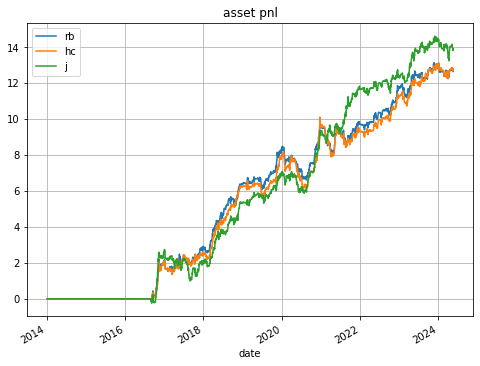

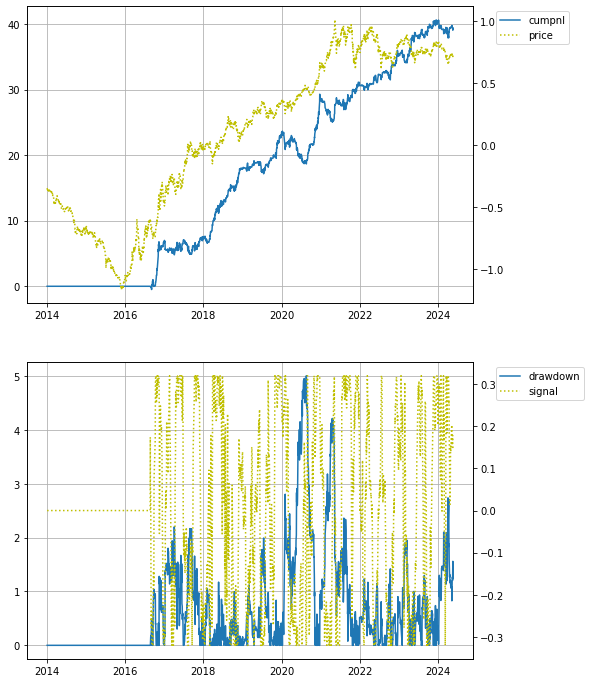

signal=fef_fly_ratio_or_qtl 
sharpe        1.134653
sharpe_6m     2.506630
sharpe_1y     2.035380
sharpe_2y     1.941477
sharpe_3y     1.243808
sharpe_4y     1.314428
sharpe_5y     1.057176
sharpe_6y     1.264773
sharpe_7y     1.347531
sharpe_8y     1.292794
sharpe_9y     1.217869
sharpe_10y    1.154862
Name: total, dtype: float64
                  rb        hc         j
sharpe      0.922149  1.024471  1.179009
sharpe_6m   2.124226  1.575925  3.401389
sharpe_1y   1.891311  1.962667  1.741029
sharpe_2y   1.942736  2.029012  1.360279
sharpe_3y   1.101130  1.164366  1.138827
sharpe_4y   1.069244  1.218834  1.294017
sharpe_5y   0.877579  1.014305  1.013594
sharpe_6y   1.051035  1.217771  1.203581
sharpe_7y   1.110668  1.255037  1.330017
sharpe_8y   1.050184  1.155156  1.343149
sharpe_9y   0.989449  1.088292  1.265267
sharpe_10y  0.938356  1.032052  1.199778
    pnl_per_trade   turnover
rb      56.326938  21.565600
hc      59.454120  21.502193
j       96.795183  21.989209


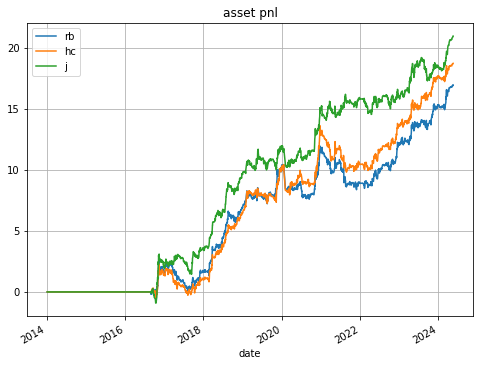

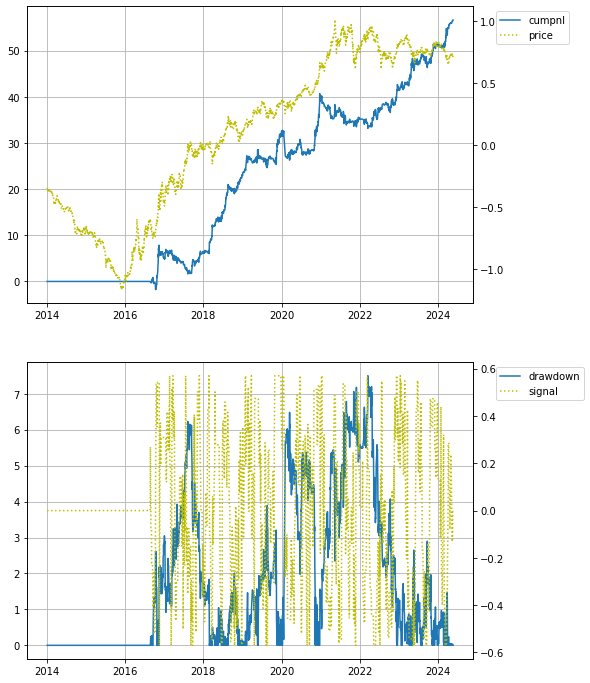

signal=fef_basmom_or_qtl 
sharpe        0.991443
sharpe_6m     1.222070
sharpe_1y     0.987820
sharpe_2y     1.679582
sharpe_3y     1.427103
sharpe_4y     1.153556
sharpe_5y     0.970576
sharpe_6y     1.073785
sharpe_7y     1.075089
sharpe_8y     1.129416
sharpe_9y     1.064056
sharpe_10y    1.009079
Name: total, dtype: float64
                  rb        hc         j
sharpe      0.873337  0.905388  0.926218
sharpe_6m   1.209966  1.508471  0.679790
sharpe_1y   0.598515  0.847706  1.223325
sharpe_2y   1.522582  1.633718  1.435906
sharpe_3y   1.228065  1.262181  1.373999
sharpe_4y   0.999635  1.060691  1.057668
sharpe_5y   0.845707  0.866612  0.925318
sharpe_6y   0.933409  0.977599  1.002643
sharpe_7y   0.963727  0.954696  1.000776
sharpe_8y   0.994543  1.020753  1.054823
sharpe_9y   0.937050  0.961733  0.993817
sharpe_10y  0.888681  0.912082  0.942497
    pnl_per_trade   turnover
rb      61.626910  18.124576
hc      60.732647  18.331998
j       92.823553  18.347571


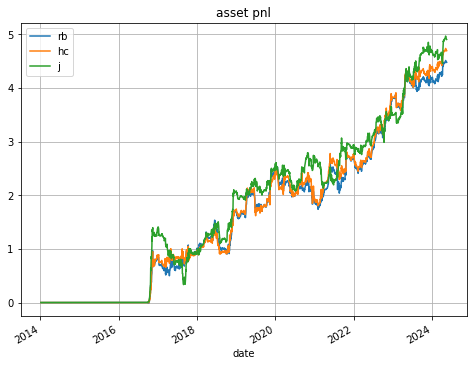

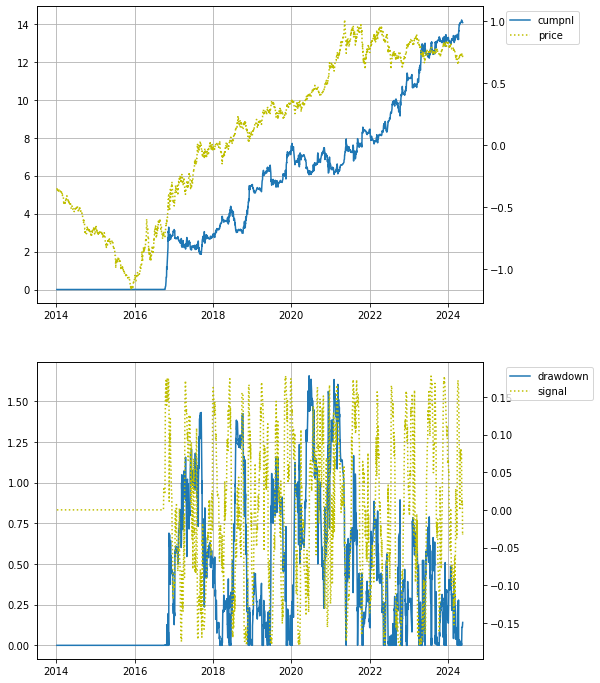

signal=fef_basmom5_or_qtl 
sharpe        1.077035
sharpe_6m     0.635102
sharpe_1y     0.660777
sharpe_2y     1.196314
sharpe_3y     1.254114
sharpe_4y     1.034877
sharpe_5y     0.833585
sharpe_6y     1.053262
sharpe_7y     1.180135
sharpe_8y     1.227051
sharpe_9y     1.155981
sharpe_10y    1.096208
Name: total, dtype: float64
                  rb        hc         j
sharpe      0.952454  1.022710  0.983341
sharpe_6m   0.509012  0.973100  0.280985
sharpe_1y   0.439205  0.899054  0.470046
sharpe_2y   1.029174  1.307342  0.964221
sharpe_3y   1.061629  1.248289  1.112361
sharpe_4y   0.910969  1.021924  0.893247
sharpe_5y   0.714014  0.810996  0.754707
sharpe_6y   0.922104  1.049189  0.908104
sharpe_7y   1.069248  1.127739  1.031682
sharpe_8y   1.084734  1.153168  1.119952
sharpe_9y   1.021983  1.086420  1.055145
sharpe_10y  0.969198  1.030278  1.000633
    pnl_per_trade   turnover
rb      51.213539  24.212779
hc      52.014564  24.290772
j       76.509317  24.303861


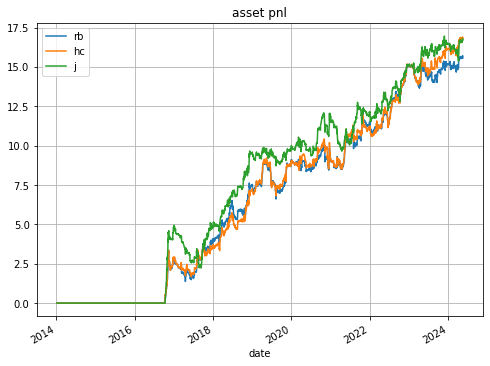

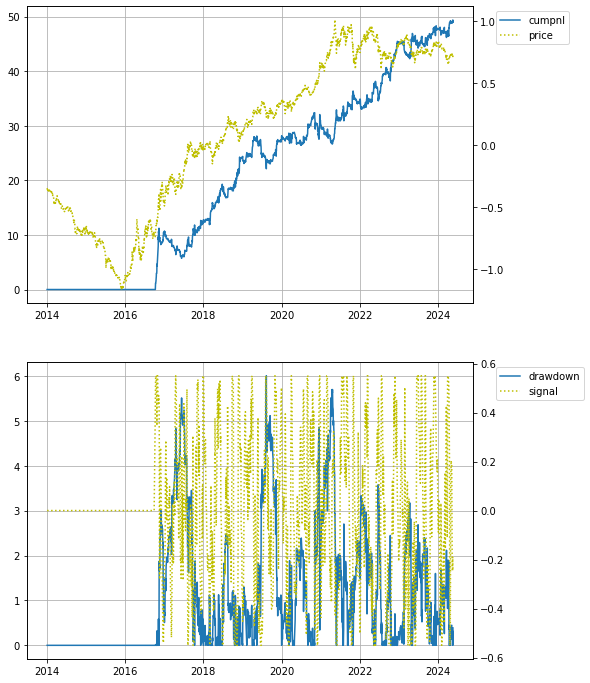

signal=combo 
sharpe        1.427489
sharpe_6m     1.377316
sharpe_1y     1.428303
sharpe_2y     1.772163
sharpe_3y     1.498393
sharpe_4y     1.489128
sharpe_5y     1.242503
sharpe_6y     1.496988
sharpe_7y     1.633226
sharpe_8y     1.627188
sharpe_9y     1.532540
sharpe_10y    1.452994
Name: total, dtype: float64
                  rb        hc         j
sharpe      1.233247  1.306302  1.380202
sharpe_6m   1.219809  1.286676  1.283234
sharpe_1y   1.212872  1.538977  1.140737
sharpe_2y   1.686432  1.894093  1.278125
sharpe_3y   1.289882  1.411113  1.375421
sharpe_4y   1.251266  1.363700  1.440901
sharpe_5y   1.043088  1.133990  1.225132
sharpe_6y   1.276618  1.394420  1.420737
sharpe_7y   1.425119  1.495323  1.541152
sharpe_8y   1.405048  1.473475  1.572843
sharpe_9y   1.323526  1.387920  1.481415
sharpe_10y  1.254983  1.315995  1.404568
    pnl_per_trade   turnover
rb      71.711070  23.568218
hc      72.176768  23.589760
j      112.564584  23.669786


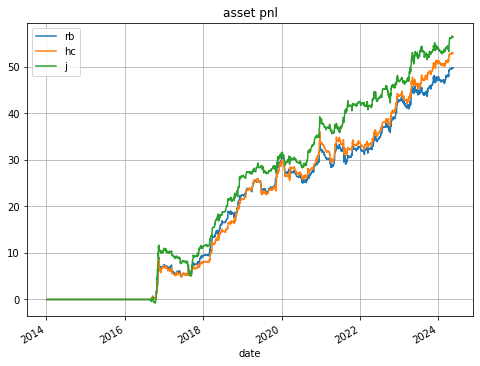

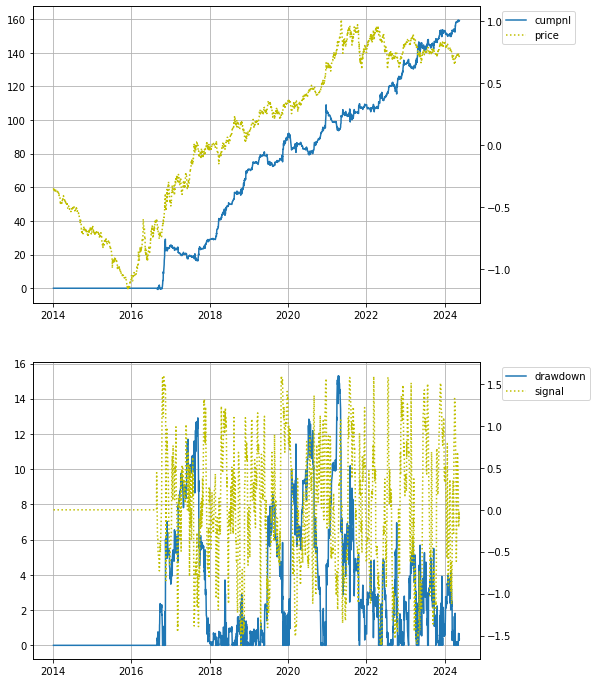

std:
fef_c1_c2_ratio_or_qtl    0.219779
fef_fly_ratio_or_qtl      0.351238
fef_basmom_or_qtl         0.099895
fef_basmom5_or_qtl        0.320647
combo                     0.770218
dtype: float64

corr:
                        fef_c1_c2_ratio_or_qtl  fef_fly_ratio_or_qtl  \
fef_c1_c2_ratio_or_qtl                1.000000              0.568240   
fef_fly_ratio_or_qtl                  0.568240              1.000000   
fef_basmom_or_qtl                     0.563520              0.368799   
fef_basmom5_or_qtl                    0.465091              0.259442   

                        fef_basmom_or_qtl  fef_basmom5_or_qtl  
fef_c1_c2_ratio_or_qtl           0.563520            0.465091  
fef_fly_ratio_or_qtl             0.368799            0.259442  
fef_basmom_or_qtl                1.000000            0.780410  
fef_basmom5_or_qtl               0.780410            1.000000  



In [95]:
pnl_df = pd.DataFrame(index=df_pxchg.index)
for signal_name in signal_dict:
    signal_df = signal_dict[signal_name]
    holding = generate_holding_from_signal(signal_df, vol_df, risk_scaling=1, asset_scaling=False)    
    bt_metrics = MetricsBase(holdings=holding[empiric_assets][cutoff:],
                             returns=df_pxchg[empiric_assets][cutoff:], shift_holdings=1)

    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=False, tenors=pnl_tenors)

    print('signal=%s \n%s' % (signal_name, pnl_stats['sharpe']))
    print(pnl_stats['asset_sharpe_stats'])
    print(pd.DataFrame({key: pnl_stats[key] for key in ['pnl_per_trade', 'turnover']}))
    pnl_df[signal_name] = pnl_stats['portfolio_pnl']['total']

    pnl_stats['asset_cumpnl'].plot(figsize=(8,6))
    plt.grid()
    plt.title('asset pnl')
    plt.show()
    plot_signal_pnl(pnl_stats['portfolio_cumpnl'], signal=signal_df.iloc[:, 0], asset_price=df_pxchg[empiric_assets[0]].cumsum(), figsize=(8, 12))

corr_cutoff = '2017-01-01'
print("std:\n%s\n" % pnl_df[corr_cutoff:].std(axis=0))

pnl_w_df = pnl_df.drop(columns=['combo']).resample('W').sum()
print("corr:\n%s\n" % pnl_w_df[corr_cutoff:].corr())

In [96]:
import pypfopt
from pypfopt import plotting
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import expected_returns

dpnl = pnl_df['2017-01-01':].drop(columns=['combo'])
dpnl = dpnl/dpnl.std()
#risk_models.sample_cov(dpnl, returns_data=True, frequency=244)

mu = None
#mu = expected_returns.ema_historical_returns(dpnl, returns_data=True, frequency=244, span=500)
S = risk_models.CovarianceShrinkage(dpnl, returns_data=True, frequency=244).ledoit_wolf()
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1)) 

fact_idx = {}

for fact in dpnl.columns:
    fact_idx[fact] = ef.tickers.index(fact)

# ef.add_constraint(lambda w: w[fact_idx['macro1']] <= 0.16)
# ef.add_constraint(lambda w: w[fact_idx['tsmom']] + w[fact_idx['macro2']] <= 0.24)

ef = EfficientFrontier(None, S, weight_bounds=(0,1))
ef.min_volatility()
#ef.max_sharpe()
port_weights = ef.clean_weights()
port_weights

OrderedDict([('fef_c1_c2_ratio_or_qtl', 0.22047),
             ('fef_fly_ratio_or_qtl', 0.35015),
             ('fef_basmom_or_qtl', 0.10182),
             ('fef_basmom5_or_qtl', 0.32757)])

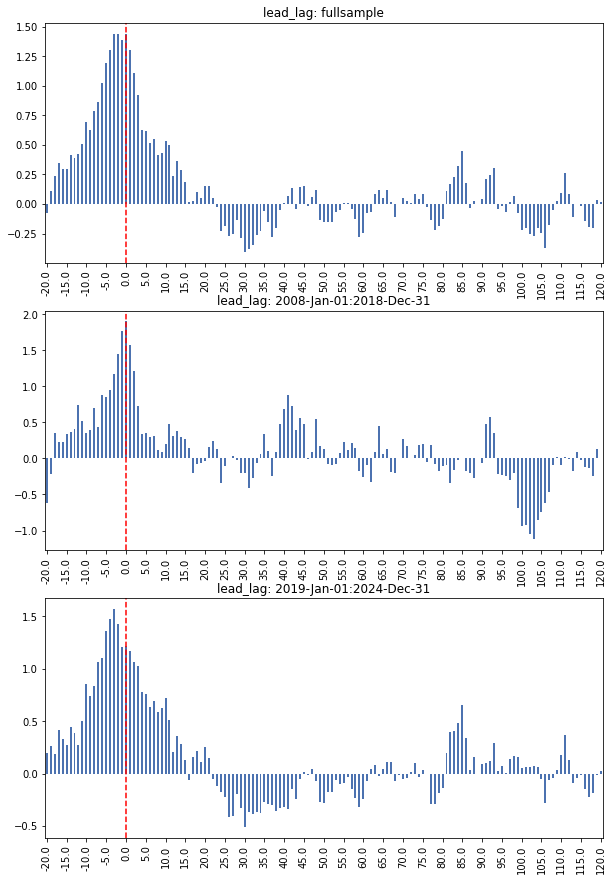

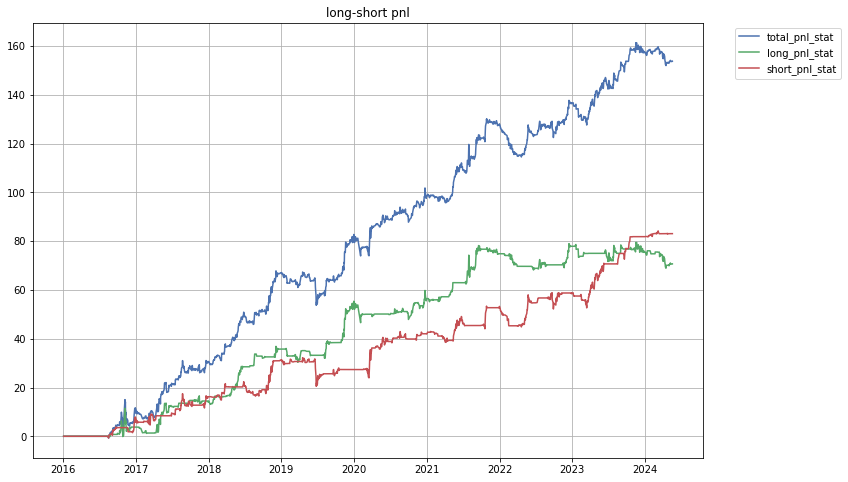

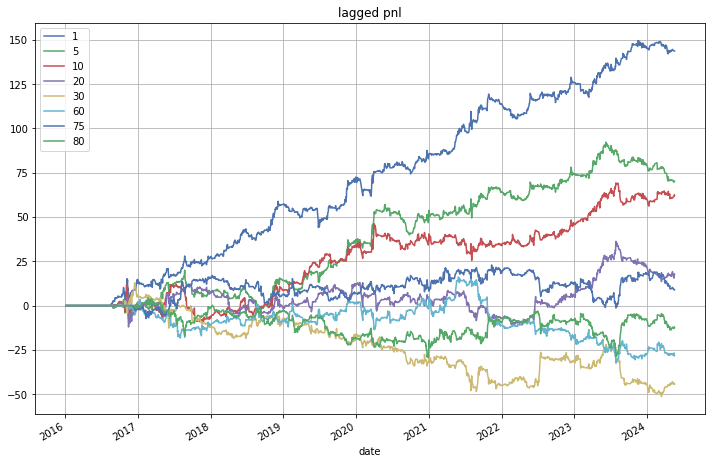

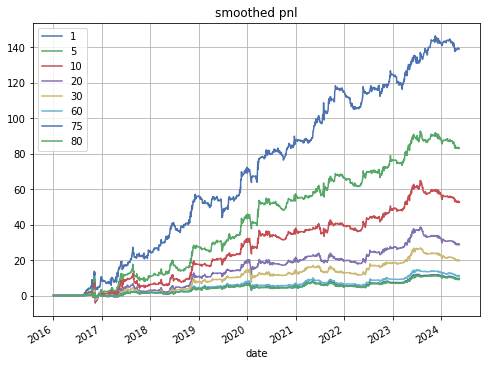

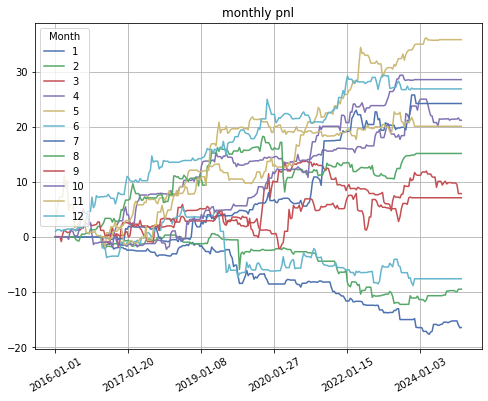

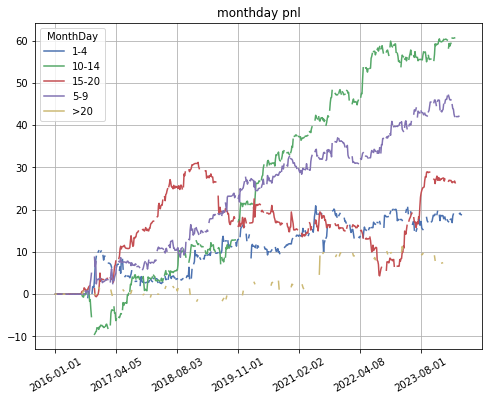

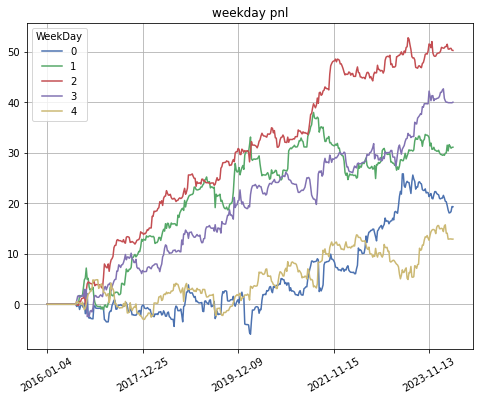

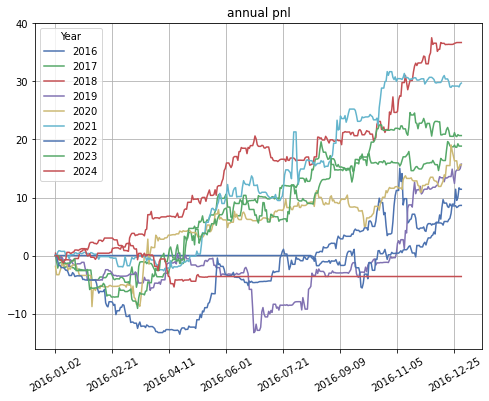

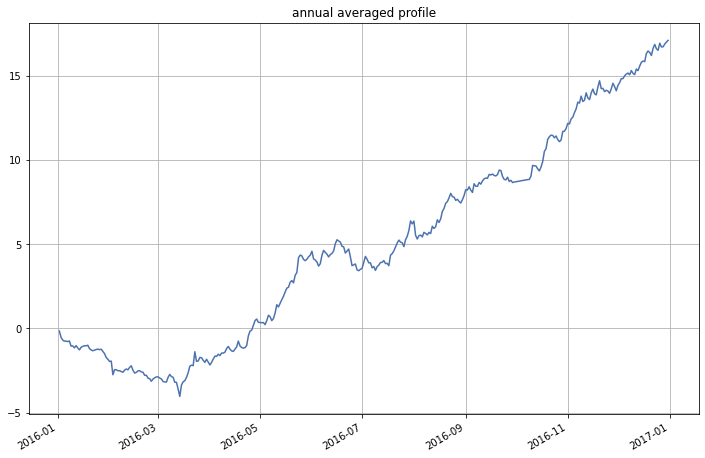

In [173]:
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2018, 12, 31)), 
                   (datetime.date(2019, 1, 1), datetime.date(2024, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


ll_left = lead_lag_config['ll_left']
ll_right = lead_lag_config['ll_right']
spacing = lead_lag_config['ll_spacing']

leadlag_df = bt_metrics.lead_lag(ll_limit_left=ll_left, 
                                 ll_limit_right=ll_right,
                                 ll_sub_windows=lead_lag_config['ll_sub_win'])

fig, ax = plt.subplots(len(ll_keys), 1)
fig.set_figheight(15)
fig.set_figwidth(10)

for i, key in enumerate(ll_keys):
    ts = leadlag_df['leadlag_sharpes'].loc[key]
    ts.plot(kind='bar', ax = ax[i], title = f'lead_lag: {key}')
    new_ticks = np.linspace(ll_left, ll_right, (ll_right-ll_left)//spacing+1)
    ax[i].set_xticks(np.interp(new_ticks, ts.index, np.arange(ts.size)))
    ax[i].set_xticklabels(new_ticks)
    ax[i].axvline(x=-ll_left, color='red', linestyle='--')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ls_pnl = bt_metrics.long_short_pnl()
for key in ls_pnl:
    ax.plot(ls_pnl[key]['portfolio_cumpnl'].index, ls_pnl[key]['portfolio_cumpnl'].values, '-', label=key)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, bbox_to_anchor=(1.04, 1), loc='upper left')
ax.grid()
plt.title("long-short pnl")
plt.show()

lagged = bt_metrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
#print('lagged PNL\n', lagged['sharpe'])
plt.grid()
plt.title('lagged pnl')
plt.show()

smoothed = bt_metrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(8, 6))
#print('smoothed PNL\n', smoothed['sharpe'])
plt.grid()
plt.title('smoothed pnl')
plt.show()

#tilt_timing = bt_metrics.tilt_timing(tilt_rolling_window=1*244) # default 3 years  tilt_rolling_window = 3 * 244 

seasonal_pnl = bt_metrics.seasonal_pnl()
cumpnl = seasonal_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('seasonal sharpe stats\n', seasonal_pnl['sharpe_stats'])
plt.grid()
plt.title('monthly pnl')
plt.show()


monthday_pnl = bt_metrics.monthday_pnl()
cumpnl = monthday_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('monthday sharpe stats\n', monthday_pnl['sharpe_stats'])
plt.grid()
plt.title('monthday pnl')
plt.show()


week_pnl = bt_metrics.week_pnl()
cumpnl = week_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('week sharpe stats\n', week_pnl['sharpe_stats'])
plt.grid()
plt.title('weekday pnl')
plt.show()


annual_pnl = bt_metrics.annual_pnl()
cumpnl = annual_pnl['cumlog_pnl']
cumpnl.set_index(cumpnl.index.astype('str')).plot(rot=30, figsize = (8, 6))
#print('annual sharpe stats\n', annual_pnl['sharpe_stats'])
plt.grid()
plt.title('annual pnl')
plt.show()

annual_pnl['cumlog_pnl'].mean(axis=1).plot()
plt.grid()
plt.title('annual averaged profile')
plt.show()

# turnover = bt_metrics.turnover()
# print(turnover)

# batch feature exploration

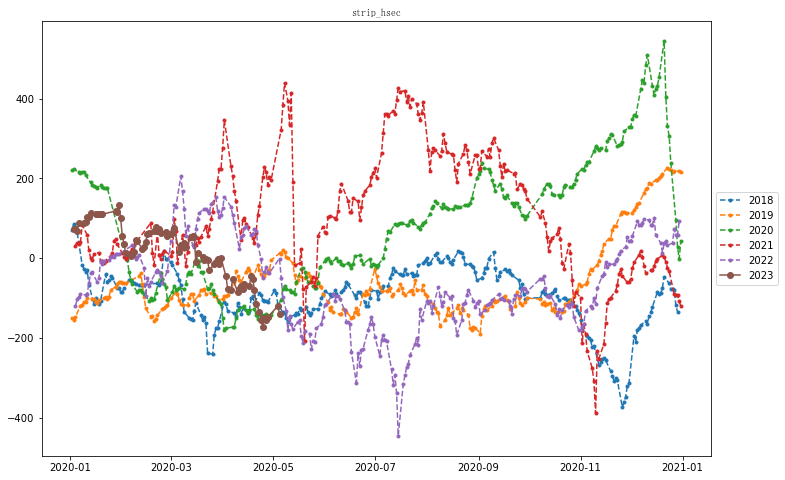

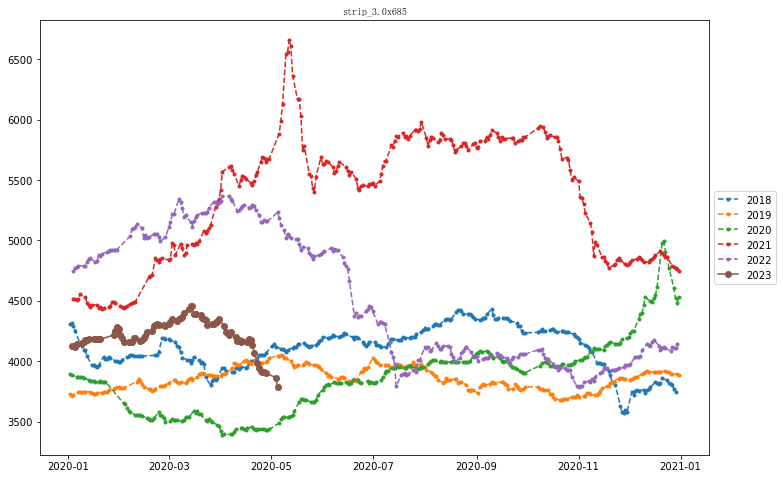

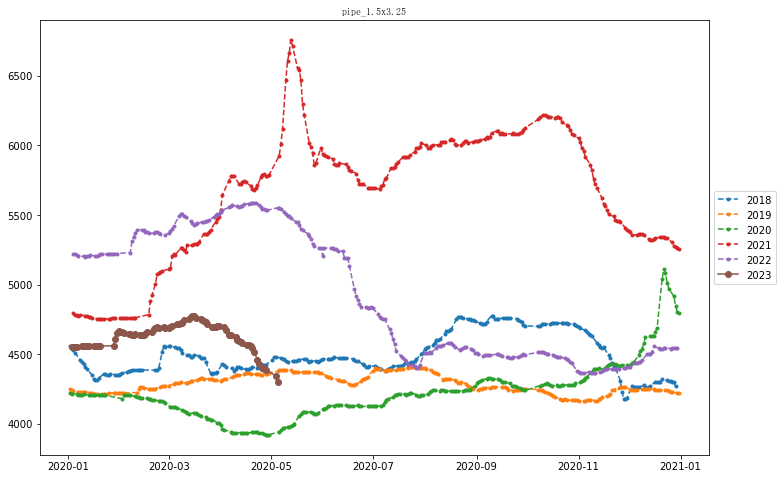

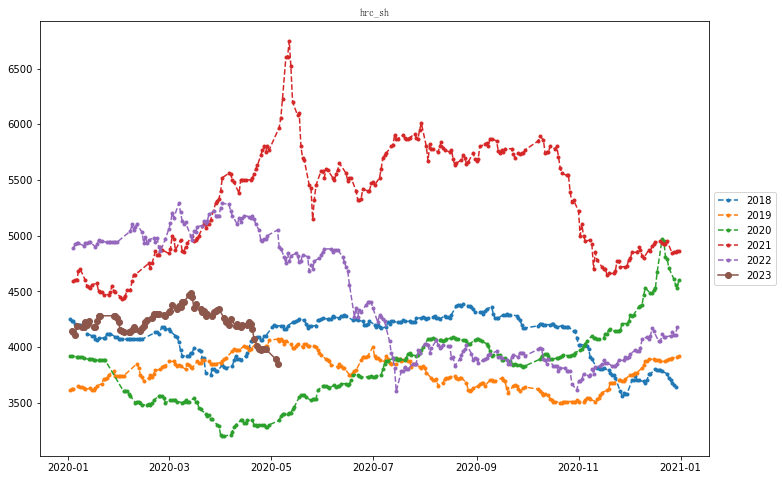

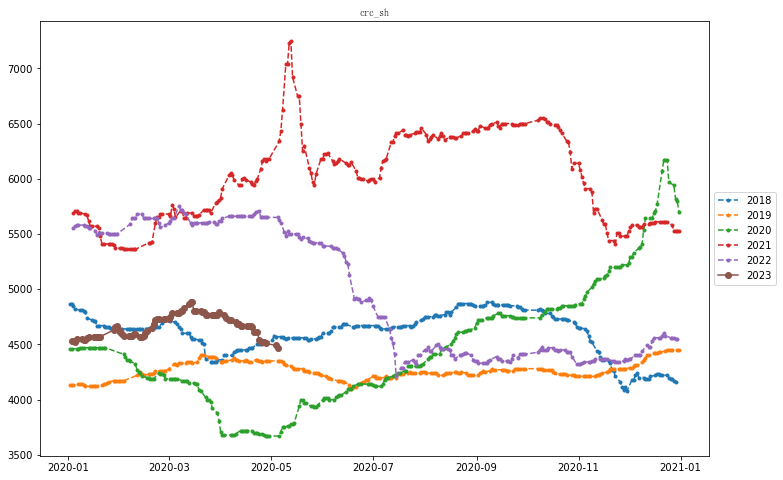

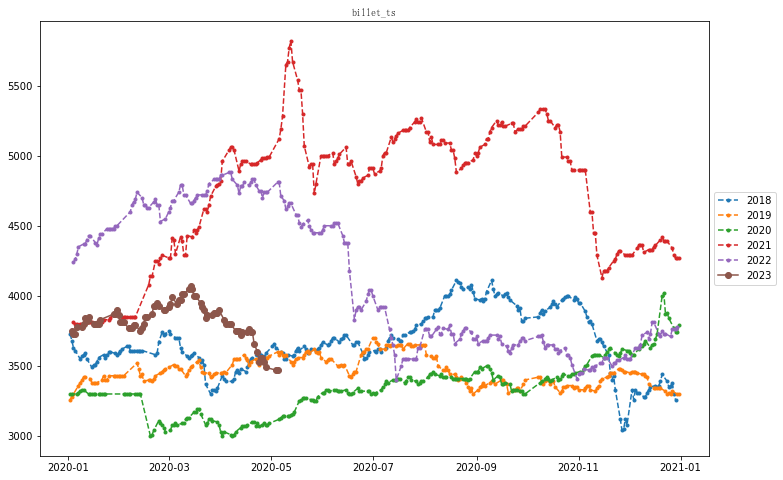

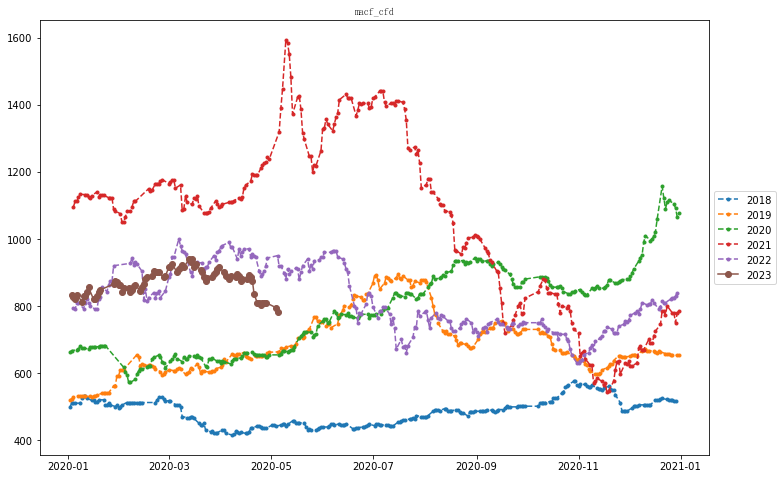

In [116]:
feature_list = [
#     'margin_hrc_sh', 
    'strip_hsec',
    'strip_3.0x685',
    'pipe_1.5x3.25',    
    'hrc_sh',
    'crc_sh',
    'billet_ts',
    'macf_cfd',
#     'gi_0.5_sh',
#     'hsec_400x200',
#     'highwire_6.5',
#     'angle_50x5',
#     'ibeam_25',
#     'channel_16',

#     'import_arb', 'pbf_prem', 'plt65_62',
#     'io_laytime_45ports', 'io_inv_imp_31ports',
#     'io_invdays_imp_mill(64)', 'io_inv_mill(64)', 'io_inv_imp_mill',
#     'io_removal_port_41',
#     'io_loading_14ports_ausbzl',
]

udf = spot_df[feature_list].dropna(how='all')
# lunar_seasonal = True

# if lunar_seasonal:
#     seasonal_signal = tstool.lunar_label(udf)
#     seasonal_signal = tstool.seasonal_group_score(
#         seasonal_signal, score_cols=feature_list, yr_col='lunar_cny',
#         group_col='lunar_wks', min_obs=3, backward=2, forward=2, rolling_years=3)
#     seasonal_signal = seasonal_signal.reindex(index=df.index).ffill()

for feature in udf.columns:
    dataseries.plot_seasonal_df(udf[feature].dropna(), cutoff='2018-01-01', title=feature)
    
signal_raw = udf[feature_list].reindex(index=df.index).ffill()


rb:strip_hsec -> SR: 1.00 -- PNL per trade: 33.08 -- Turnover: 26.72
rb:strip_3.0x685 -> SR: 1.07 -- PNL per trade: 55.20 -- Turnover: 17.46
rb:pipe_1.5x3.25 -> SR: 0.85 -- PNL per trade: 53.25 -- Turnover: 14.26
rb:hrc_sh -> SR: 1.11 -- PNL per trade: 46.67 -- Turnover: 21.92
rb:crc_sh -> SR: 1.03 -- PNL per trade: 60.39 -- Turnover: 15.17
rb:billet_ts -> SR: 0.85 -- PNL per trade: 30.21 -- Turnover: 26.18
rb:macf_cfd -> SR: 1.18 -- PNL per trade: 77.03 -- Turnover: 13.00


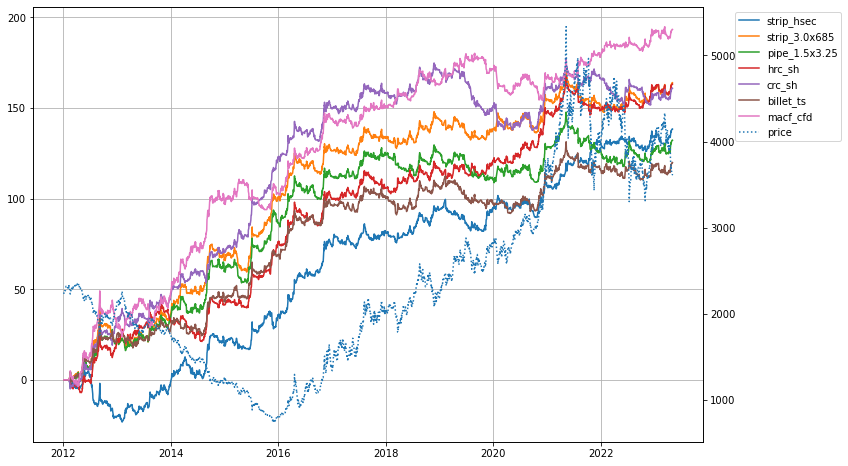

hc:strip_hsec -> SR: 1.25 -- PNL per trade: 42.52 -- Turnover: 28.27
hc:strip_3.0x685 -> SR: 0.96 -- PNL per trade: 49.43 -- Turnover: 19.23
hc:pipe_1.5x3.25 -> SR: 0.72 -- PNL per trade: 49.98 -- Turnover: 13.95
hc:hrc_sh -> SR: 1.26 -- PNL per trade: 54.48 -- Turnover: 23.52
hc:crc_sh -> SR: 0.87 -- PNL per trade: 53.23 -- Turnover: 16.00
hc:billet_ts -> SR: 0.71 -- PNL per trade: 27.15 -- Turnover: 26.33
hc:macf_cfd -> SR: 0.89 -- PNL per trade: 48.24 -- Turnover: 17.91


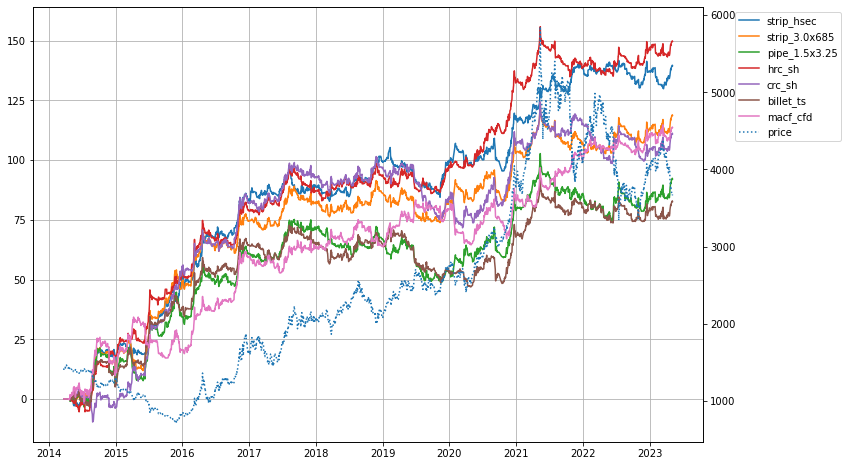

i:strip_hsec -> SR: 1.37 -- PNL per trade: 74.96 -- Turnover: 26.70
i:strip_3.0x685 -> SR: 1.02 -- PNL per trade: 81.14 -- Turnover: 18.90
i:pipe_1.5x3.25 -> SR: 0.76 -- PNL per trade: 79.20 -- Turnover: 14.08
i:hrc_sh -> SR: 1.05 -- PNL per trade: 70.10 -- Turnover: 23.09
i:crc_sh -> SR: 0.73 -- PNL per trade: 67.10 -- Turnover: 16.17
i:billet_ts -> SR: 0.85 -- PNL per trade: 49.90 -- Turnover: 26.78
i:macf_cfd -> SR: 1.52 -- PNL per trade: 132.16 -- Turnover: 16.51


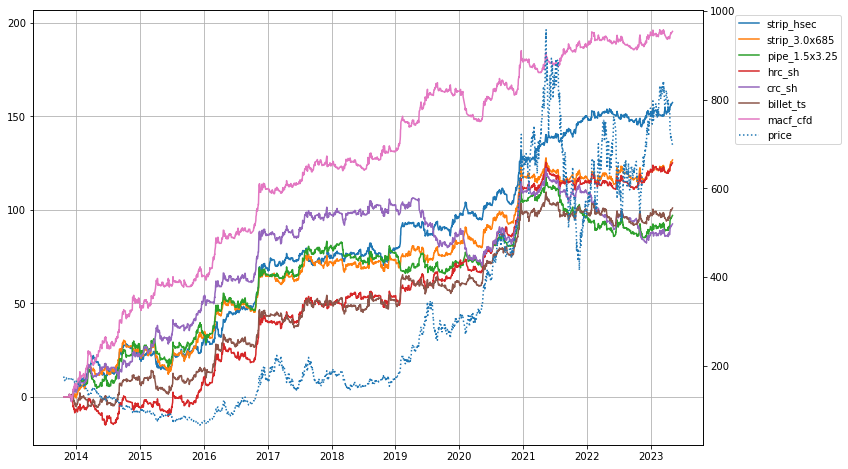

j:strip_hsec -> SR: 1.26 -- PNL per trade: 53.79 -- Turnover: 27.92
j:strip_3.0x685 -> SR: 1.37 -- PNL per trade: 89.78 -- Turnover: 17.88
j:pipe_1.5x3.25 -> SR: 1.49 -- PNL per trade: 121.06 -- Turnover: 14.14
j:hrc_sh -> SR: 1.07 -- PNL per trade: 59.06 -- Turnover: 22.09
j:crc_sh -> SR: 1.50 -- PNL per trade: 115.20 -- Turnover: 15.14
j:billet_ts -> SR: 1.23 -- PNL per trade: 56.59 -- Turnover: 26.66
j:macf_cfd -> SR: 1.32 -- PNL per trade: 109.48 -- Turnover: 13.21


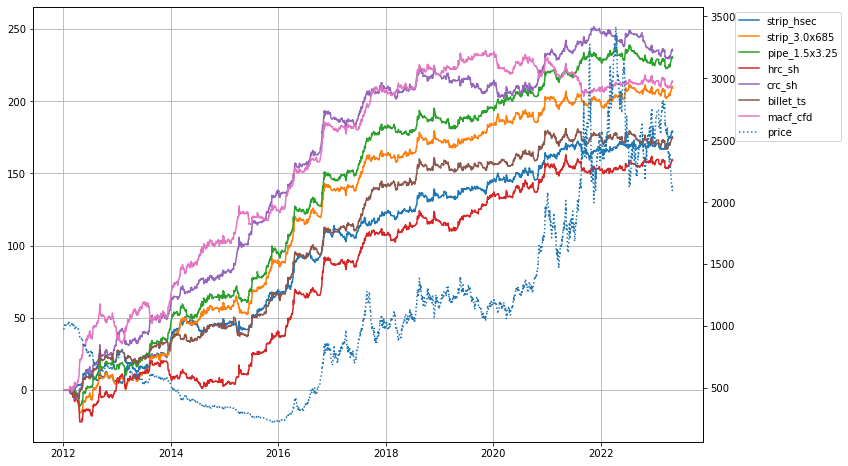

jm:strip_hsec -> SR: 1.11 -- PNL per trade: 47.05 -- Turnover: 27.42
jm:strip_3.0x685 -> SR: 1.10 -- PNL per trade: 69.23 -- Turnover: 18.61
jm:pipe_1.5x3.25 -> SR: 1.11 -- PNL per trade: 91.50 -- Turnover: 13.80
jm:hrc_sh -> SR: 0.74 -- PNL per trade: 38.50 -- Turnover: 23.06
jm:crc_sh -> SR: 1.26 -- PNL per trade: 93.10 -- Turnover: 15.35
jm:billet_ts -> SR: 0.85 -- PNL per trade: 37.64 -- Turnover: 27.50
jm:macf_cfd -> SR: 0.93 -- PNL per trade: 65.74 -- Turnover: 15.77


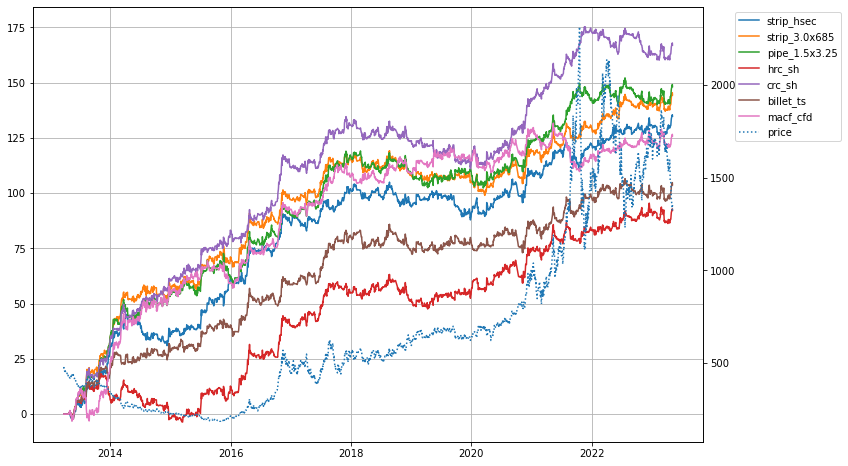

SF:strip_hsec -> SR: 0.18 -- PNL per trade: 6.28 -- Turnover: 30.83
SF:strip_3.0x685 -> SR: 0.70 -- PNL per trade: 35.25 -- Turnover: 21.70
SF:pipe_1.5x3.25 -> SR: 0.89 -- PNL per trade: 61.14 -- Turnover: 15.48
SF:hrc_sh -> SR: 0.94 -- PNL per trade: 42.61 -- Turnover: 24.70
SF:crc_sh -> SR: 1.28 -- PNL per trade: 86.06 -- Turnover: 15.70
SF:billet_ts -> SR: 0.69 -- PNL per trade: 28.08 -- Turnover: 27.31
SF:macf_cfd -> SR: 0.66 -- PNL per trade: 31.76 -- Turnover: 22.86


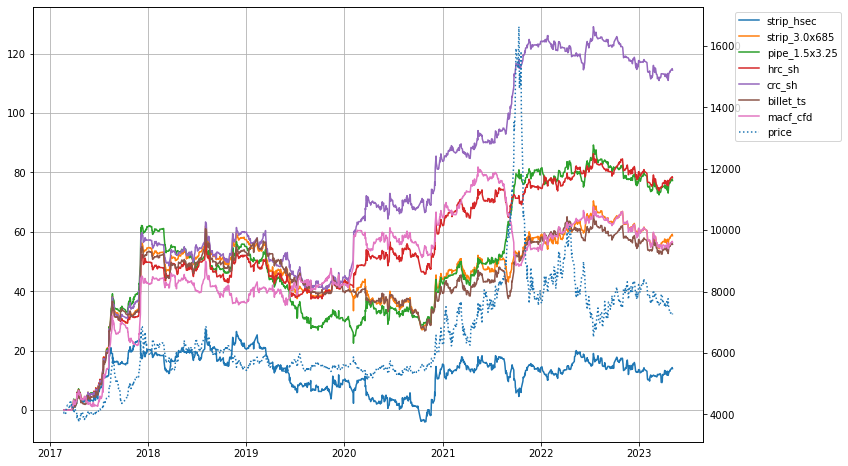

FG:strip_hsec -> SR: 1.09 -- PNL per trade: 38.09 -- Turnover: 29.64
FG:strip_3.0x685 -> SR: 0.48 -- PNL per trade: 25.14 -- Turnover: 20.07
FG:pipe_1.5x3.25 -> SR: 0.31 -- PNL per trade: 21.01 -- Turnover: 14.80
FG:hrc_sh -> SR: 0.87 -- PNL per trade: 38.18 -- Turnover: 23.47
FG:crc_sh -> SR: 0.40 -- PNL per trade: 24.92 -- Turnover: 16.19
FG:billet_ts -> SR: 0.76 -- PNL per trade: 29.74 -- Turnover: 26.37
FG:macf_cfd -> SR: 0.65 -- PNL per trade: 33.69 -- Turnover: 19.86


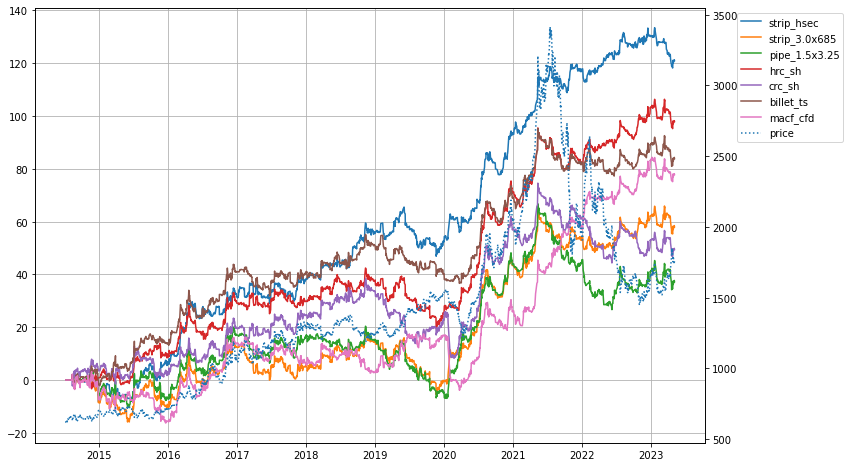

In [118]:
cutoff = '2012-01-01'
signal_func = 'qtl'
param_rng = [20, 42, 2]
signal_cap = None # [-2, 2]
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'SF', 'FG', ] # 'v', 'cu', 'al', 'ss', 'UR', 'SA', 'ru'

for asset in product_list:
    if '_' in asset:
        price_ts = (1 + beta_ret_dict[asset]).cumprod().to_frame('price')[cutoff:]
    else:
        price_ts = df[(asset, 'c1', 'close')].dropna().to_frame('price')[cutoff:]
    pnl_list = [price_ts]
    for feature in feature_list:
        feature_ts = udf[feature].reindex(index=price_ts.index).ffill()
        #feature_ts = feature_ts.pct_change(5)
        #feature_ts = tstool.lunar_yoy(feature_ts, group_col='lunar_days', func='pct_change')
        #feature_ts = tstool.seasonal_score(feature_ts.to_frame())
        signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
        asset_df = pd.concat([price_ts, signal_ts], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price'])
        asset_df['position'] = (asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset}:{feature} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        pnl_list.append(asset_df['pnl'].cumsum().to_frame(feature))
    pnl_df = pd.concat(pnl_list, axis=1)
    dataseries.plot_df_on_2ax(pnl_df, left_on=feature_list, right_on=['price'])
    

# signal grid search run

In [ ]:
signal_list = []

for feature in feature_list:
    for win in [20, 40, 60, 80, 120, 240]:
        signal_name = f"{feature}:ma:{win}"
        signal_raw[signal_name] = signal_raw[feature] - signal_raw[feature].rolling(win).mean()
        signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
        signal_list.append(signal_name)
        
        signal_name = f"{feature}:ewmac:{win}"
        signal_raw[signal_name] = dh.ewmac(signal_raw[feature], win_s=win/10, ls_ratio=2)
        signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
        signal_list.append(signal_name)

#         signal_name = f"{feature}:convewm:{win}"
#         signal_raw[signal_name] = dh.conv_ewm(signal_raw[feature], h1s=[win//10, win//10*2], h2s=[win//10*3, win//10*6])
#         signal_raw[signal_name] = dh.risk_normalized(signal_raw[signal_name], 60)
#         signal_list.append(signal_name)
        
        signal_name = f"{feature}:zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:zscore_dff20:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature].diff(20), win=win)
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:qtl:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        
        signal_name = f"{feature}:qtl_dff20:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature].diff(20), win=win)*2
        signal_list.append(signal_name)
        
        signal_name = f"{feature}:lunar_wks_score:{win}"
        signal_raw[signal_name] = seasonal_signal[feature]
        signal_list.append(signal_name)
        
        signal_prefix = f"{feature}:seasonal_score"
        signal_raw[signal_prefix] = tstool.seasonal_score(signal_raw[feature].to_frame())
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)
        
        signal_prefix = f"{feature}:yoy"
        signal_raw[signal_prefix] = signal_raw[feature]/signal_raw[feature].shift(244)-1
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)

        signal_prefix = f"{feature}:lunar_yoy"
        signal_raw[signal_prefix] = tstool.lunar_yoy(signal_raw[feature], group_col='lunar_days', func='pct_change')
        signal_name = f"{signal_prefix}_pct:{win}"
        signal_raw[signal_name] = dh.pct_score(signal_raw[feature], win=win)*2
        signal_list.append(signal_name) 
        signal_name = f"{signal_prefix}_zscore:{win}"
        signal_raw[signal_name] = dh.zscore_roll(signal_raw[feature], win=win)
        signal_list.append(signal_name)
        
signal_raw = signal_raw.reindex(index=df.index).ffill()

In [ ]:
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'v', 'FG', 'SM', 'SF']
cutoff = pd.Timestamp('2012-07-01')

for sig in signal_list:
    print(sig)
    pnl_by_asset = {}
    pnl_df = pd.DataFrame()
    pos_df = pd.DataFrame()
    for asset in product_list:
        signal = signal_raw[sig]
        asset_df = pd.concat([df[(asset, 'c1', 'close')], signal], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price']).ffill()
        asset_df['position'] = (asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        
        pnl_by_asset[asset] = asset_df
        pnl_df[asset] = asset_df['pnl']
        pos_df[asset] = asset_df['position']
    pnl_df = pnl_df.fillna(0)
    pos_df = pos_df.ffill()
    total_sr = = np.sqrt(244) * pnl_df.sum(axis=1).mean()/pnl_df.sum(axis=1).std()
    print(f'Total SR: {total_sr:.2f}')
    
    cumpn; = pnl_df.cumsum()
    cumpnl.plot()
    plt.title(sig)
    plt.show()
    cum_pnl.sum(axis=1).plot()
    plt.title(sig)
    plt.show()
    

# Signal portfolio

In [111]:
signal_dict_full = {
    'i': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 0.5),
        #('io_inv_mill(64)_lyoy_mom', 0.5),
        
        ('io_invdays_imp_mill(64)_lvl_fast', 0.5),
        #('io_invdays_imp_mill(64)_lyoy_mom', 0.5),
        
#         ('steel_social_inv_lvl_fast', 1.0/1.0),
#         ('rebar_inv_social_lyoy_fast', 0.25/1.0),
#         ('wirerod_inv_social_lyoy_fast', 0.25/1.0),
#         ('hrc_inv_social_lyoy_fast', 0.25/1.0),
#         ('crc_inv_social_lyoy_fast', 0.25/1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),
        ('macf_cfd_lvl_mid', 1.0),
#         ('pbf_prem_yoy', 0.5/15),
#         ('cons_steel_lyoy_slow', 1.0/1.5),
#         ('sea_export_arb_lvl_mid', 1.0/1.4),
    ],
    'rb': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('rebar_inv_social_lyoy_fast', 1.0),
#         ('wirerod_inv_social_lyoy_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
    'hc': [
        ('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        ('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('hrc_inv_social_lyoy_fast', 1.0),
#         ('crc_inv_social_lyoy_fast', 1.0),        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),  
    ],
    'j': [
        #('io_removal_lvl_fast', 1.0), 
        #('io_removal_lyoy_mom', 1.0),
        
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('steel_social_inv_lvl_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
    'jm': [
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
#         ('steel_social_inv_lvl_fast', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),     
    ],
    'FG': [
        #('io_inv_mill(64)_lvl_fast', 1.0),
        #('io_inv_mill(64)_lyoy_mom', 1.0),
        
        ('margin_lvl_fast', 1.0),
        ('strip_hsec_lvl_mid', 1.0),    
    ],
}

i:io_removal_lvl_fast -> SR: 1.44 -- PNL per trade: 125.18 -- Turnover: 16.32
i:io_inv_mill(64)_lvl_fast -> SR: 1.06 -- PNL per trade: 124.63 -- Turnover: 12.02
i:io_invdays_imp_mill(64)_lvl_fast -> SR: 1.08 -- PNL per trade: 96.53 -- Turnover: 16.77
i:margin_lvl_fast -> SR: 1.41 -- PNL per trade: 98.64 -- Turnover: 20.34
i:strip_hsec_lvl_mid -> SR: 1.35 -- PNL per trade: 101.73 -- Turnover: 19.64
i:macf_cfd_lvl_mid -> SR: 1.24 -- PNL per trade: 150.45 -- Turnover: 12.07
i:total -> SR: 1.92 -- PNL per trade: 173.72 -- Turnover: 17.79
io_removal_lvl_fast                 0.829607
io_inv_mill(64)_lvl_fast            0.438992
io_invdays_imp_mill(64)_lvl_fast    0.402572
margin_lvl_fast                     0.849863
strip_hsec_lvl_mid                  0.776010
macf_cfd_lvl_mid                    0.864912
dtype: float64


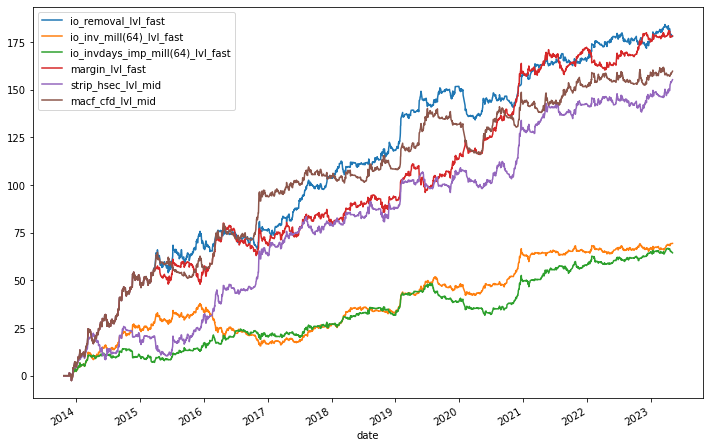

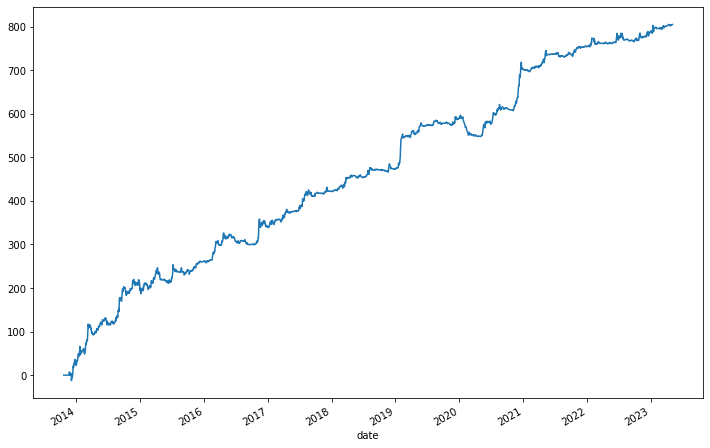

rb:io_removal_lvl_fast -> SR: 1.14 -- PNL per trade: 82.35 -- Turnover: 10.73
rb:io_inv_mill(64)_lvl_fast -> SR: 0.90 -- PNL per trade: 81.30 -- Turnover: 8.63
rb:margin_lvl_fast -> SR: 1.13 -- PNL per trade: 67.99 -- Turnover: 12.88
rb:strip_hsec_lvl_mid -> SR: 0.88 -- PNL per trade: 39.16 -- Turnover: 19.54
rb:total -> SR: 1.30 -- PNL per trade: 87.76 -- Turnover: 12.28
io_removal_lvl_fast         0.941461
io_inv_mill(64)_lvl_fast    0.974576
margin_lvl_fast             0.951824
strip_hsec_lvl_mid          0.813721
dtype: float64


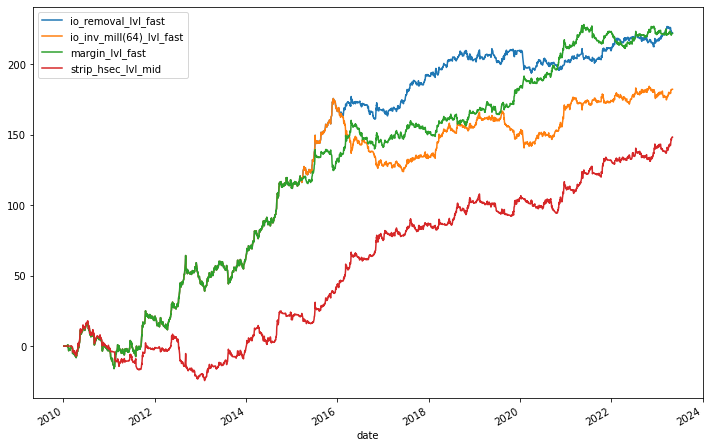

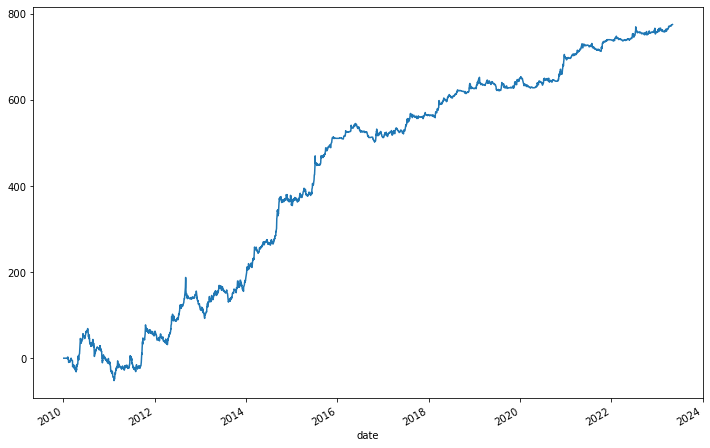

hc:io_removal_lvl_fast -> SR: 1.11 -- PNL per trade: 59.73 -- Turnover: 17.62
hc:io_inv_mill(64)_lvl_fast -> SR: 0.77 -- PNL per trade: 55.45 -- Turnover: 13.05
hc:margin_lvl_fast -> SR: 1.10 -- PNL per trade: 47.66 -- Turnover: 22.04
hc:strip_hsec_lvl_mid -> SR: 1.34 -- PNL per trade: 62.48 -- Turnover: 21.46
hc:total -> SR: 1.54 -- PNL per trade: 78.61 -- Turnover: 20.48
io_removal_lvl_fast         0.852830
io_inv_mill(64)_lvl_fast    0.902805
margin_lvl_fast             0.871381
strip_hsec_lvl_mid          0.780406
dtype: float64


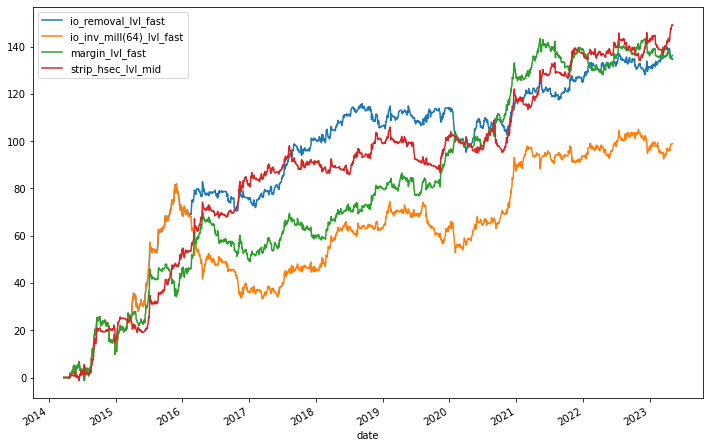

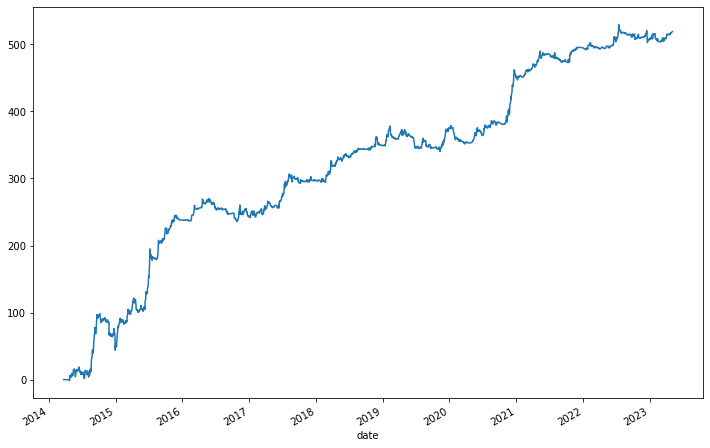

j:margin_lvl_fast -> SR: 1.72 -- PNL per trade: 123.09 -- Turnover: 14.65
j:strip_hsec_lvl_mid -> SR: 1.35 -- PNL per trade: 71.61 -- Turnover: 21.87
j:total -> SR: 1.84 -- PNL per trade: 111.75 -- Turnover: 20.35
margin_lvl_fast       0.940847
strip_hsec_lvl_mid    0.792106
dtype: float64


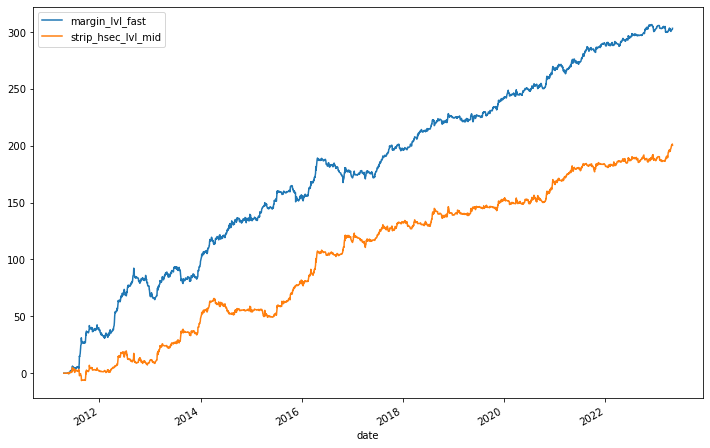

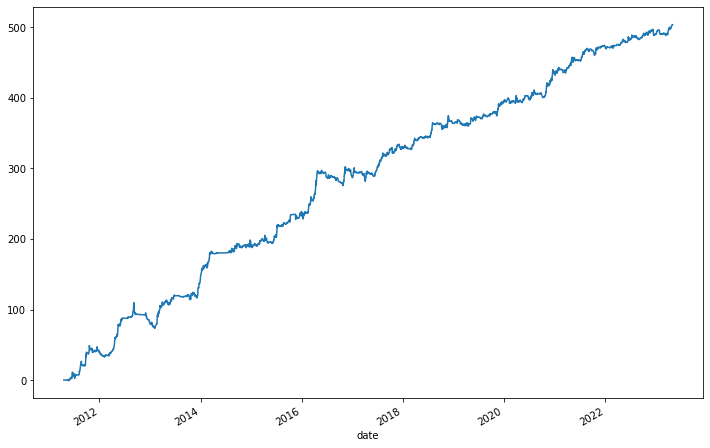

jm:margin_lvl_fast -> SR: 1.19 -- PNL per trade: 70.76 -- Turnover: 18.68
jm:strip_hsec_lvl_mid -> SR: 1.32 -- PNL per trade: 76.23 -- Turnover: 20.36
jm:total -> SR: 1.48 -- PNL per trade: 84.74 -- Turnover: 21.66
margin_lvl_fast       0.854962
strip_hsec_lvl_mid    0.761956
dtype: float64


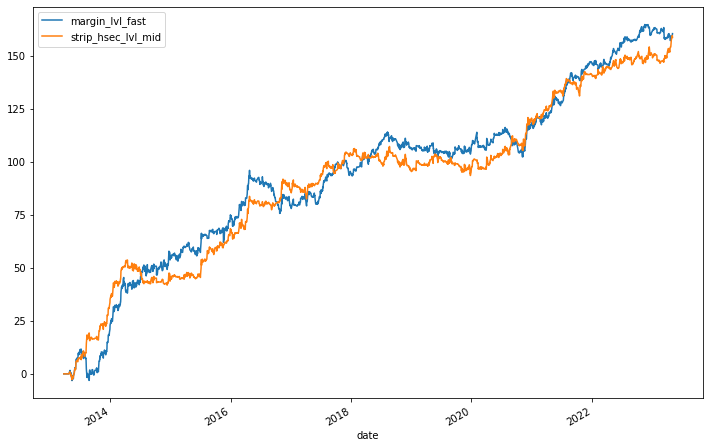

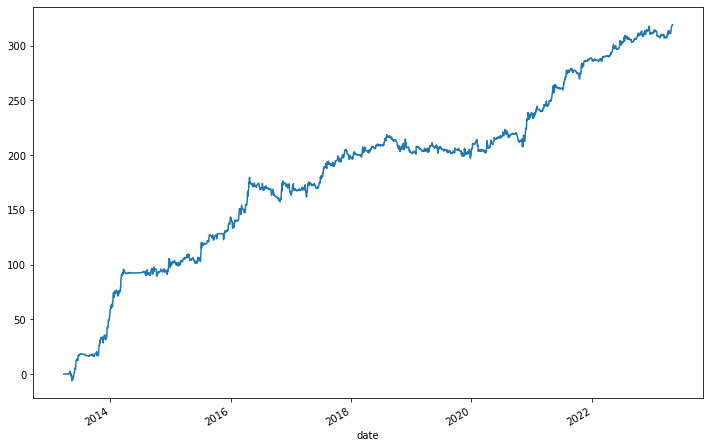

In [112]:
signal_dict = signal_dict_full

signal_diagnosis = False

pnl_dict = {}
pos_dict = {}

for asset in ['i', 'rb', 'hc', 'j', 'jm']:
    if '_' in asset:
        price_ts = (1 + beta_ret_dict[asset]).cumprod().to_frame('price')
    else:
        price_ts = df[(asset, 'c1', 'close')].dropna().to_frame('price')
    pnl_list = []
    pos_list = []
    for idx, (feature_name, weight) in enumerate(signal_dict[asset]):
        feature, signal_func, param_rng, proc_func, chg_func, bullish, freq = signal_repo[feature_name]
        if freq == 'price':
            feature_ts = spot_df[feature].ffill().reindex(index=price_ts.index).ffill()
        elif len(freq) > 0:
            feature_ts = spot_df[feature].ffill().reindex(index=pd.date_range(start=df.index[0], end=df.index[-1], freq=freq)).ffill()
        else:
            feature_ts = spot_df[feature].dropna()
        
        if 'yoy' in proc_func:
            if 'lunar' in proc_func:
                label_func = lunar_label
                label_args = {}
            else:
                label_func = calendar_label
                label_args = {'anchor_date': {'month': 1, 'day': 1}}
            if '_wk' in proc_func:
                group_col = 'label_wk'
            else:
                group_col = 'label_day'
            feature_ts = yoy_generic(feature_ts, label_func=label_func, group_col='label_day', func=chg_func, label_args=label_args)
        elif 'df' in proc_func:
            n_diff = int(proc_func[2:])
            feature_ts = getattr(feature_ts, chg_func)(n_diff)
    
        if signal_func == 'seasonal_score_w':
            signal_ts = seasonal_score(feature_ts.to_frame(), backward=10, forward=10, rolling_years=3, min_obs=10).reindex(index=df.index).ffill()
        elif signal_func == 'seasonal_score_d':
            signal_ts = seasonal_score(feature_ts.to_frame(), backward=15, forward=15, rolling_years=3, min_obs=30)
        elif len(signal_func)>0:
            feature_ts = feature_ts.reindex(index=df.index).ffill()
            signal_ts = calc_conv_signal(feature_ts, signal_func=signal_func, param_rng=param_rng, signal_cap=signal_cap)
        else:
            signal_ts = feature_ts.reindex(index=df.index).ffill()
            
        if not bullish:
            signal_ts = -signal_ts
            
        asset_df = pd.concat([price_ts, signal_ts], axis=1)
        asset_df.columns = ['price', 'signal']
        asset_df['signal'] = asset_df['signal'].apply(lambda x: x).ffill()
        asset_df = asset_df.dropna(subset=['price'])
        asset_df['position'] = (weight*asset_df['signal']/asset_df['price'].pct_change().rolling(20).std()).shift(1).fillna(0)
        asset_df['pnl'] = (asset_df['position'].shift(1) * asset_df['price'].pct_change()).fillna(0)
        
        std = asset_df['pnl'].std()
        sr = np.sqrt(244) * asset_df['pnl'].mean()/asset_df['pnl'].std()
        pnl_per_trade = 100 * 100 * asset_df['pnl'].mean()/asset_df['position'].diff().abs().mean()
        turnover = 100 * asset_df['position'].diff().abs().mean()/asset_df['position'].abs().mean()
        print(f'{asset}:{feature_name} -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
        pnl_list.append(asset_df['pnl'].to_frame(feature_name))
        pos_list.append(asset_df['position'].to_frame(feature_name))
        
    pnl_df = pd.concat(pnl_list, axis=1)
    pos_df = pd.concat(pos_list, axis=1)
    sum_pnl = pnl_df.sum(axis=1)
    sum_pos = pos_df.sum(axis=1)
    sr = np.sqrt(244) * sum_pnl.mean()/sum_pnl.std()
    pnl_per_trade = 100 * 100 * sum_pnl.mean()/sum_pos.diff().abs().mean()
    turnover = 100 * sum_pos.diff().abs().mean()/sum_pos.abs().mean()
    print(f'{asset}:total -> SR: {sr:.2f} -- PNL per trade: {pnl_per_trade:.2f} -- Turnover: {turnover:.2f}')
    
    print(pnl_df.std())
    pnl_dict[asset] = pnl_df
    pos_dict[asset] = pos_df
    pnl_df.cumsum().plot()
    plt.show()
    sum_pnl.cumsum().plot()
    plt.show()


In [10]:
fill_backward = False
smooth_win = 1
sig_smooth = tstool.exp_smooth(df_in, hl = smooth_win, fill_backward=fill_backward)

demean = False
mean_win = 244
vol_win = 244
if demean:
    sig_scored = tstool.ts_score(sig_smooth, hl_mean=mean_win, min_obs_mean=mean_win, fill_backward_mean=fill_backward, 
                          hl_vol=vol_win, min_obs_vol=vol_win, fill_backward_vol=fill_backward)
else:
    sig_scored = tstool.ts_scale(sig_smooth, hl = vol_win, min_obs=vol_win, fill_backward=fill_backward)

#sig_scored = tstool.xs_score(sig_smooth, demean=demean, hl=vol_win)

signal_cap = 2.0

score_capped = tstool.cap(sig_scored, -signal_cap, signal_cap)
score_filled = tstool.filldown(score_capped, 2)
score = tstool.lag(score_filled, 1)


In [ ]:
vol_scale = 20
asset_vol = tstool.exp_smooth(df_pxchg**2, hl=vol_scale, fill_backward=fill_backward)**0.5
holding = score/asset_vol

commod_list = holding.columns #['hc']
btmetrics = MetricsBase(holdings = holding[commod_list], returns = df_pxchg[commod_list])